<a href="https://colab.research.google.com/github/PabloMurer/Data_Science_II/blob/main/Data_Science_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


 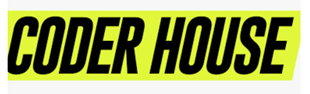

# **PRIMERA ENTREGA DATA SCIENCE II**

## ABSTRACT

El presente trabajo se centra en el analisis de informacion disponible sobre los vuelos dentro del territorio de los EEUU desde 2019 a 2023 inclusive.

Durante el desarrollo, se pretende interpretar las principales caracteristicas del sistema de aviacion estadounidense en lo que refiere a distribucion y cantidad de aeropuertos, principales rutas, ademas de otras importantes caracteristicas, pero **fundamentalmente, el grado cumplimiento de horario de despegue/salida y aterrizaje/llegada**, persiguiendo alcanzar algunas conclusiones sobre los motivos que implican una eventual demora, el tiempo previsto y la probabilidad o prediccion de incurrir en una demora.

El trabajo se focaliza en la utilizacion de un fragmento de dicho dataset tomando solamente el año 2023 debido razones de limitaciones de espacio y manipulacion de datos.

Para finalizar, me parece importante aclarar la motivacion de la tematica seleccionada constituye una motivacion personal, siendo a mi entender el sistema de aviacion un sistema de suma importancia en la interconexion de un mundo cada vez mas ligado, ya sea por razones de turismo, negocio o estudio, pero principalmente, de una gran complejidad al avacar multiples variables como ser el clima, tamaños de ciudades, oferta y demanda, entre otras.



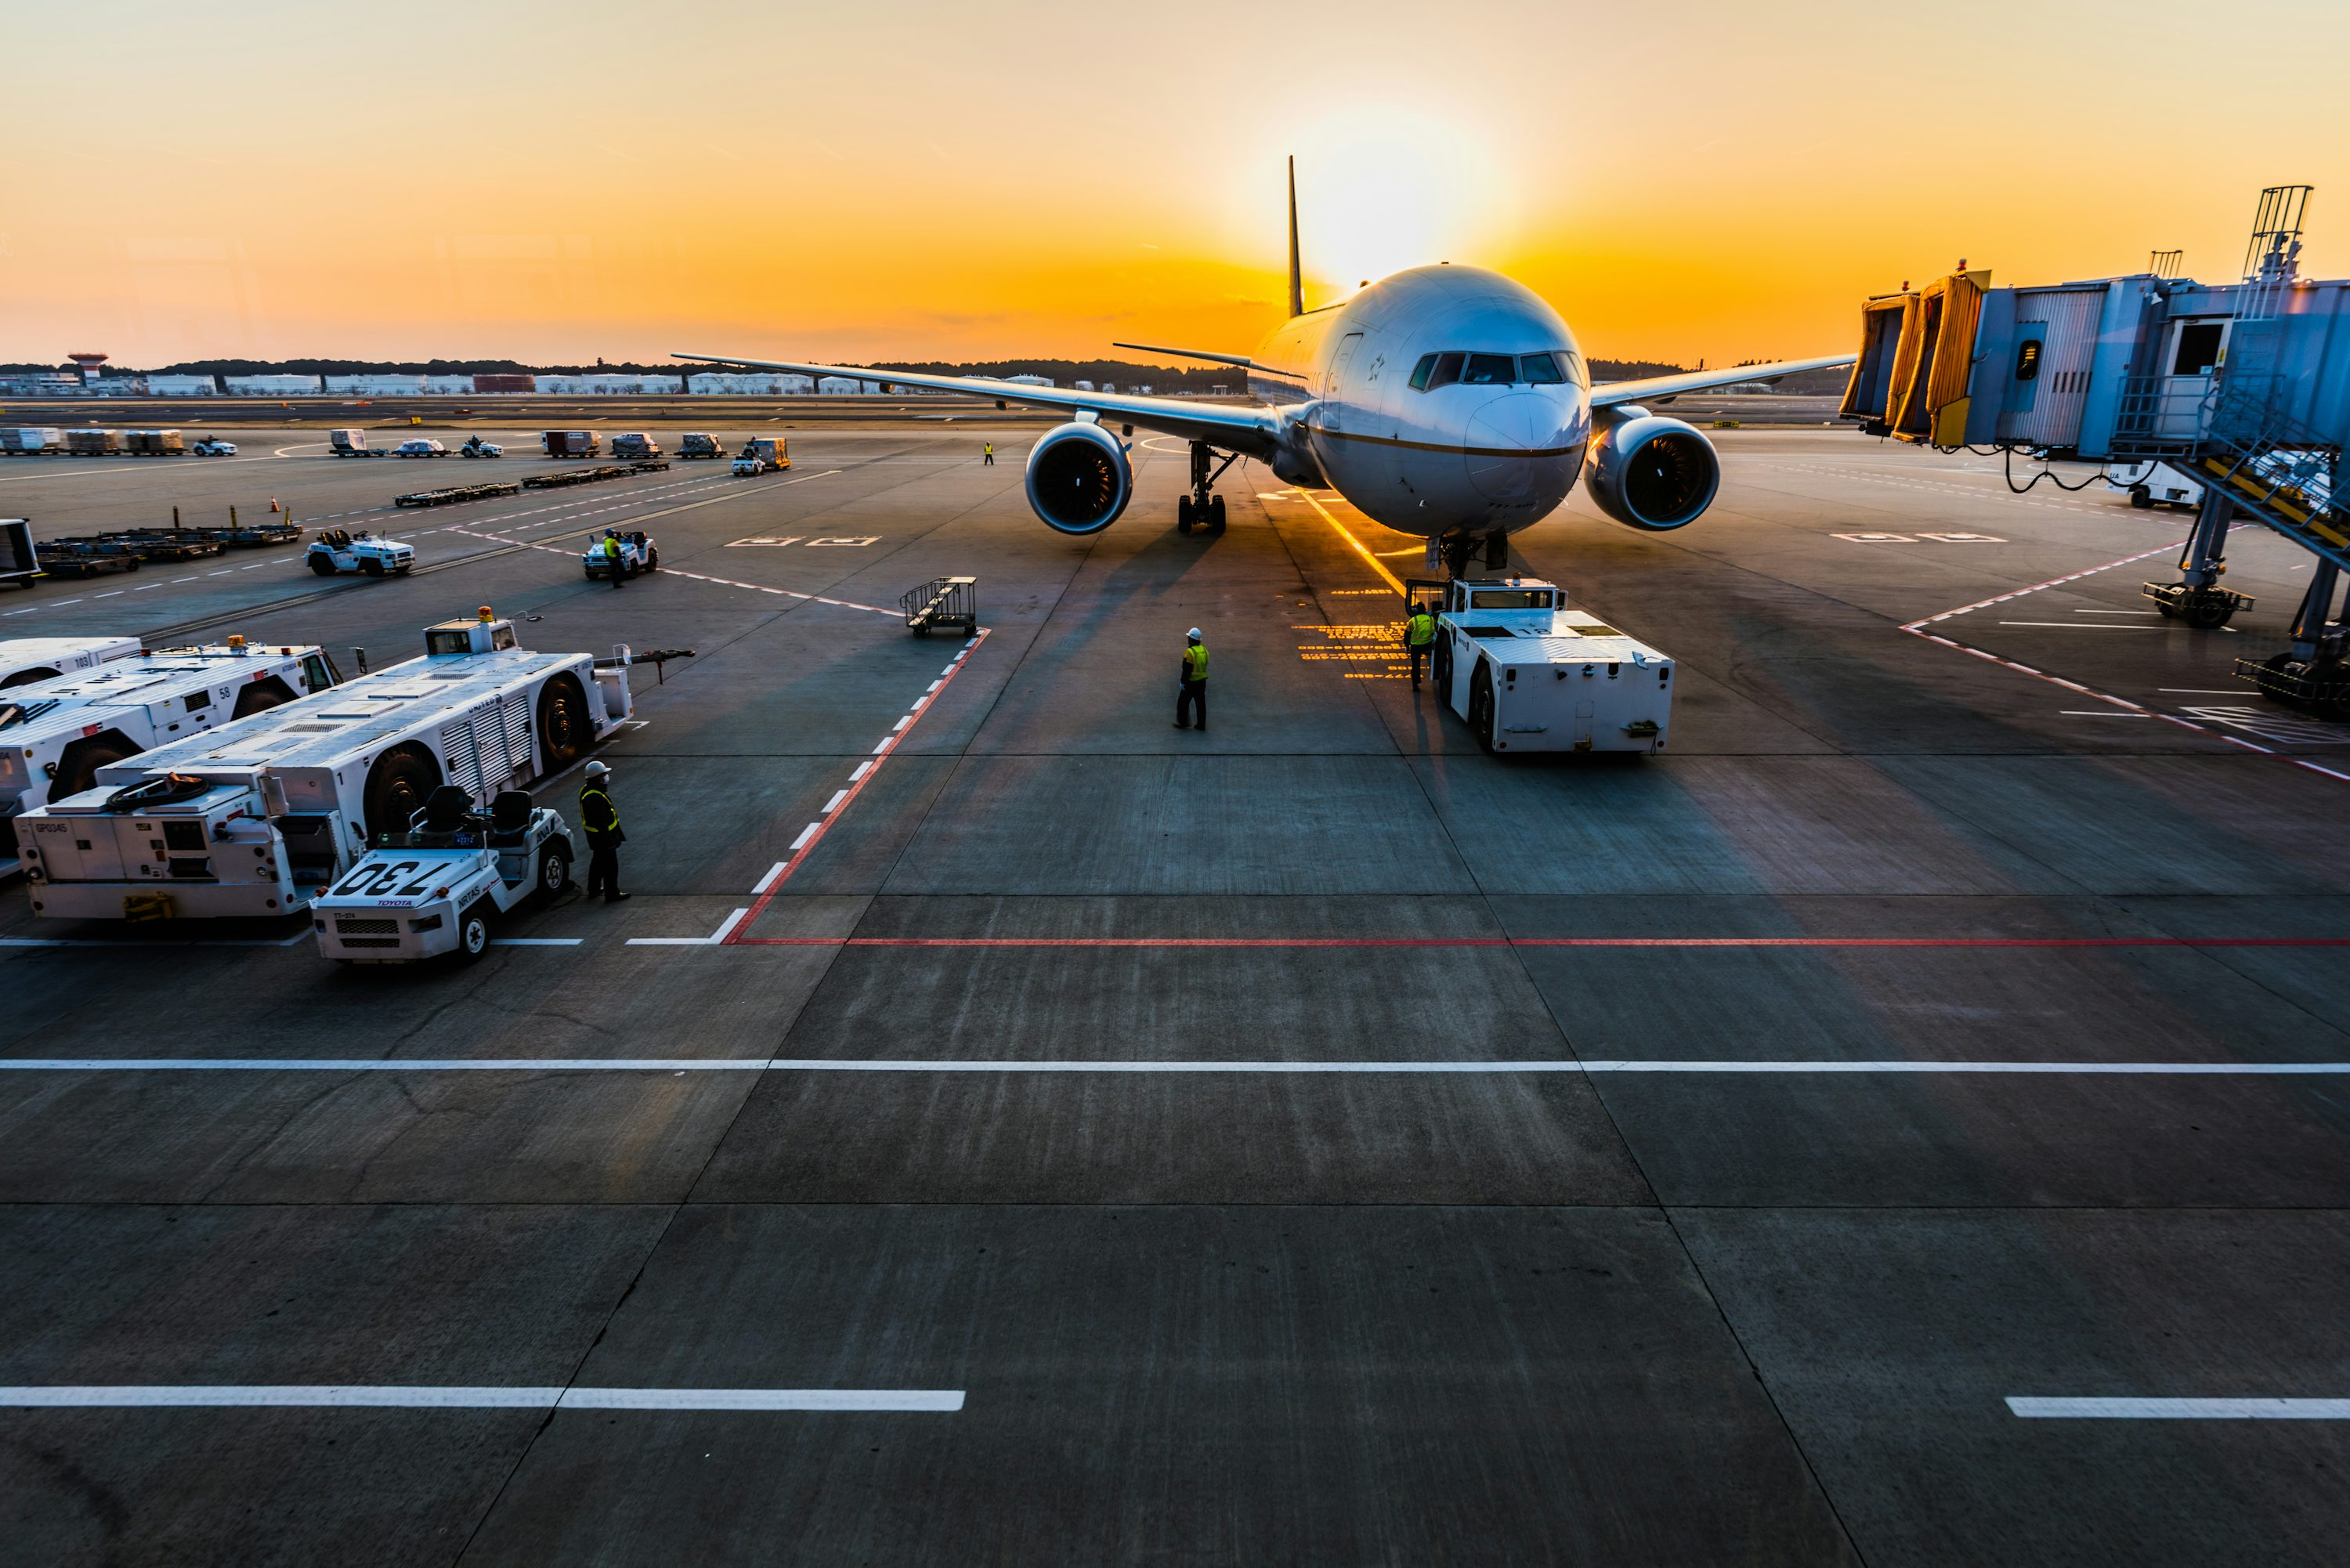
---------------------------------------------------------------------------


## 0. INTRODUCCION

Según un informe de 2010 elaborado por la Administración Federal de Aviación de Estados Unidos (FAA), el impacto económico de los retrasos en los vuelos nacionales de los Estados Unidos supone un costo anual de 32.900 millones de dólares para los pasajeros, las aerolíneas y otros sectores de la economía.

Más de la mitad de esa cantidad proviene del bolsillo de los pasajeros, que no solo pierden tiempo esperando la salida de sus aviones, sino que también pierden conexiones, gastan dinero en comida y tienen que dormir en hoteles mientras están varados.

El informe, basado en datos de 2007, estimó que los retrasos en el transporte aéreo supusieron una merma de 4.000 millones de dólares en el PBI del país ese año.

Dicho todo lo anterior, debiera ser de interes de todas las partes involucradas (personas, compañias aereas y gobiernos) entender el motivo de eventuales retrasos y hasta intentar predecirlos y/o estimarlos.

Los datos provienen del siguiente dataframe descargado del sigueinte link:

https://www.kaggle.com/code/alperenkaran/visualization-of-flight-delays/notebook?select=_ALL_FLIGHTS_30m.csv

Este tiene 30 millones de registros y 32 columnas.
El mismo, se basa sobre datos de retrasos y cancelaciones de vuelos de aerolíneas dentro de los EEUU, en el periodo de agosto de 2019 - agosto de 2023.

Las fuentes allí citadas son el Departamento de Transporte de EE. UU., Oficina de Estadísticas de Transporte
https://www.transtats.bts.gov .

Por ultimo, se aclara que se utiliza un segundo dataframe con informacion de los aeropuertos de EEUU.

El mismo se denomina airports.csv y se extrae del siguiente link:

https://www.kaggle.com/code/nancyalaswad90/airline-on-time-data-visualization


## 1. PLANTEO DE OBJETIVOS

Inicialmente, planteamos los siguientes objetivos e hipotesis:

- Predecir la posibilida de que un vuelo sea demorado (ya sea en la salida o llegada). En ese caso, estimar el posible tiempo de demora y motivos mas probables.

- Analizar el sistema estadounidense de aviacion, caracteritizando distribucion de aeropuertos, principales rutas, cantidad de viajes y grado de confiabilidad del mismo.

Como hipotesis, entendemos se trata de una industria muy afectada por multiples imprevistos, lo cual hiciera suponer el grado de probabilidad de incurrir en una demora es elevado. Estas demoras, se suponen mas asociadas a cuestiones climaticas o de alta demanda del sistema, aspecto que debiera agudizarse en las principales rutas.

Por ultimo, la audiencia a la que se encuentra dirigido el presente trabajo es toda aquella persona con conocimientos basicos de analisis de datos y algun grado de curiosidad sobre sistema de aviaciones y vuelos.

## 2. LECTURA INICIAL DE DATOS






### 2.1 Importacion de librerias

In [1]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')

### 2.2 Conexion con Drive de google para importacion de dataframes

In [2]:
# Configuramos el entorno de Python en Google Colab
from google.colab import drive
import os

drive.mount("/content/drive")
print(os.getcwd())

os.chdir("/content/drive/My Drive/Data Science II")
print(os.getcwd())

Mounted at /content/drive
/content
/content/drive/My Drive/Data Science II


### 2.3 Importacion Dataframe principal (DF1)

In [3]:
# Aclaracion: Por el tamaño del archivo (30 millones de filas y 32 columnas), se pretende analizar solo el año 2023.
# Para ello, la lectura de datos se hace por bloques y luego se concatenan en un unico archivo.
# Caso contrario, la ejecucion daba error por exceder memoria RAM.

# Ruta al archivo CSV
archivo = 'flights.csv'

# Tamaño del bloque (segun memoria RAM)
chunk_size= 1_000_000

# Año que desamos filtrar
Año_objetivo=2023

# Lista para almacenar los datos filtrados
Datos_filtrados = []

# Leer el archivo por bloques
for bloque in pd.read_csv(archivo, chunksize = chunk_size):
    filtrado = bloque[bloque['FL_DATE'].str.startswith(str(Año_objetivo))]
    Datos_filtrados.append(filtrado)

# Unir todos los datos filtrados
resultado2023 = pd.concat(Datos_filtrados)

In [4]:
# Copio el dataframe originado para manipular/modificar.
# Solo lo hacemos con el dataframe principal por el tamaño que tiene.

df1 = resultado2023.copy()

### 2.4 Importacion Dataframe 2 (DF2): Contiene informacion de aeropuertos de EEUU

In [5]:
# Lectura de dataframe2 (que contiene la latitud y longitud de cada aeropuertode EEUU)

airports = pd.read_csv('airports.csv')

## 3. INSPECCION INICIAL DE DATAFRAMES

### 3.1 Dataframe principal DF1

#### 3.1.1 Descripcion de variables:

* **V0- FL_DATE:** "Flight Date" o fecha de vuelo. Es de ***tipo object*** y tiene el siguiente formato: "YYYY-MM-DD".

* **V1- AIRLINE:** Nombre de la aerolinea. Es de ***tipo object***.

* **V2- AIRLINE_DOT:** Se procederá a eliminar dado que es redundante con la variable V1 y V3. Es una concatenacion entre las columnas AIRLINE Y AIRLINE_CODE y es de ***tipo object***.

* **V3- AIRLINE_CODE:** Codigo de la aerolinea. El código de aerolínea (también conocido como código IATA) es una abreviatura de dos letras que identifica a la aerolínea. Este código se utiliza en diversos sistemas de reserva, como billetes de avión e información de embarque, para facilitar la identificación de la aerolínea involucrada en un vuelo. Es de ***tipo object***.

* **V4- DOT_CODE:** Es un codigo o ID (nro entero) de identificación asignado por el Departamento de Transporte de EE. UU. para identificar a una aerolínea (transportista) única. Es de ***tipo integer***.

* **V5- FL_NUMBER:** Es un numero que identifica un servicio en particular, refiriendonos a servicio con un viaje en particular, tomando siempre la misma ciudad de origen y destino (o ruta).

  Cada aerolínea tiene su propio método para asignarlos. Sin embargo, existen algunas reglas generales en la industria:

  - Para empezar, todos los números de vuelo deben estar comprendidos entre el 1 y el 9999. Es de ***tipo integer.***

  - Salvo excepciones, hay un orden interno en la asignación de estas cifras. Los números pares suelen indicar vuelos que salen del norte y del este, y los impares vuelos que salen del sur y del oeste.

  - Los dígitos más bajos indican que se trata de vuelos históricamente importantes o de gran relevancia dentro de la organización interna de las aerolíneas.

  - Los viajes de regreso suelen tener el dígito siguiente al vuelo de ida: es decir, si el BA1 llega a Nueva York, al volver a Londres se convertirá en el BA2. Esto acontece en todas las aerolíneas. Vueling, por ejemplo, cuando vuela de Ibiza a Barcelona usa el VY3515 y de Barcelona a Ibiza, el VY3516.

* **V6- ORIGEN:** Nombre del aeropuerto de origen. Es de ***tipo object***.

* **V7- ORIGIN_CITY:** Nombre de la ciudad donde esta ubicado el aeropuerto de origen. Es de ***tipo object***.

* **V8- DEST:** Nombre del aeropuerto de destino. Es de ***tipo object***.

* **V9- DEST_CITY:** Nombre de la ciudad donde esta ubicado el aeropuerto de destino. Es de ***tipo object***.

* **V10- CRS_DEP_TIME:** Se refiere a la hora de salida programada de la aeronave tal como se indica en el sistema de reservas (CRS - Computer Reservation System). Esta hora es la hora en la que está previsto que el avión salga de la puerta de embarque, no la hora en la que esta previsto que despegue. Es de ***tipo integer***.

* **V11- DEP-TIME:** Se refiere a la hora de salida real de la aeronave. Esta hora es la hora real en la que el avión salió de la puerta de embarque, no la hora en la que realmente despegó (tiene un tiempo de demora entre la la salida de la puerta hasta llegar a la pista y despegar efectivamente). Es de ***tipo float***.

* **V12- DEP-DELAY:** Diferencia en minutos entre la hora de salida programada y la real (V11-V10). Los aviones que salieron de la puerta de embarque antes de lo programado tienen un DEP_DELAY negativo. Es de ***tipo float***.

* **V13- TAXI_OUT:** Tiempo que tarda la aeronave en desplazarse desde el lugar de estacionamiento en la terminal hasta la pista, lista para el despegue. Esta variable esta expresada en minutos. Es de ***tipo float***.

* **V14- WHEELS_OFF :** Es una expresión técnica utilizada para designar el momento/horario en el que el avión despega, es decir, cuando las ruedas se levantan del suelo. Es de ***tipo float***.

* **V15- WHEELS_ON :** Es una expresión técnica utilizada para designar el momento/horario en el que el avión aterriza, es decir, cuando las ruedas de un avión tocan el suelo. Es de ***tipo float***.

* **V16- TAXI_IN:** Tiempo que tarda la aeronave en desplazarse desde la pista hasta el lugar de estacionamiento en la terminal, después del aterrizaje. Esta variable esta expresada en minutos. Es de ***tipo float***.

* **V17- CRS_ARR_TIME:** Se refiere a la hora de llegada programada de la aeronave tal como se indica en el sistema de reservas (CRS - Computer Reservation System). Esta hora es la hora en la que está previsto que el avión llegue a la puerta de desembarque, no la hora en la que esta previsto que aterrice. Es de ***tipo integer***.

* **V18- ARR_TIME:** Se refiere a la hora de llegada real de la aeronave. Esta hora es la hora real en la que el avión llegó a la puerta de desembarque, no la hora en que aterrizó. Es de ***tipo float***.

* **V19- ARR_DELAY:** Diferencia en minutos entre la hora de llegada programada y la real (V18-V17). Los aviones que a la puerta de desembarque antes de lo programado tienen un ARR_DELAY negativo. Es de ***tipo float***.

* **V20- CANCELLED:** Indica si el vuelvo fue o no cancelado (1 = fue cancelado). Es de ***tipo float***.

* **V21- CANCELLATION_CODE:** Código que especifica el motivo de la cancelación del vuelo. Es de ***tipo object***.

  Los códigos de cancelación de vuelo "A", "B" y "C" indican el motivo de la cancelación según la Administración Federal de Aviación (FAA). "A" significa que la cancelación fue causada por la aerolínea, "B" se refiere a las condiciones climáticas y "C" indica un problema con la Administración Nacional de Aviación.

* **V22-DIVERTED:** Variable que indica si un vuelo es desviado o no, es decir, aterriza en un aeropuerto/destino diferente al planificado (1 = fue desviado). Es de ***tipo float***.

  Un vuelo desviado es aquel que, por alguna circunstancia imprevista, se ve obligado a aterrizar en un aeropuerto distinto al de su destino original. Las razones por las que se desvía un vuelo pueden incluir problemas técnicos, emergencias médicas, condiciones climáticas adversas o incluso decisiones de la aerolínea.

* **V23-CRS_ELAPSED_TIME:** Esta variable indica el tiempo esperado de vuelo, incluyendo el tiempo total del avion en vuelo (aire) mas tiempo de maniobras (en suelo) (segun el sistema CRS - Sistema de Reservas Computarizado). La variable esta expresada en minutos. Es de ***tipo float***.

* **V24-ELAPSED_TIME:** Esta variable indica el tiempo real de vuelo en minutos (en el aire mas tiempo de maniobra). Es de ***tipo float***.

* **V25-AIR-TIME:** Esta variable indica el tiempo real de vuelo (solo en el aire). Esta expresada en minutos. Es de ***tipo float***.

* **V26-DISTANCE:** Distancia entre dos aeropuertos (expresado en millas). Es de ***tipo float***.

* **V27-DELAY_DUE_CARRIER:** Se refiere a un retraso de vuelo que resulta de problemas o decisiones de la aerolínea (expresado en minutos).
Esto podría incluir situaciones como problemas de mantenimiento de la aeronave, problemas con la tripulación, retrasos en la limpieza o carga de la aeronave o incluso retrasos en la salida debido a decisiones de la aerolínea. Es de ***tipo float***.

* **V28-DELAY_DUE_WEATHER:** Se refiere a un retraso de vuelo que resulta de problemas o contingencias climáticas (expresado en minutos).

* **V29-DELAY_DUE_NAS:** Los retrasos del Sistema Nacional del Espacio Aéreo (NAS) se refieren a retrasos de vuelos que se atribuyen a problemas dentro del propio sistema, como el volumen de tráfico, fallas de los equipos o las condiciones de la pista, entre otros (expresado en minutos). Es de ***tipo float***.

* **V30-DELAY_DUE_SECURITY:** Un retraso debido a la seguridad de la aerolínea puede ocurrir por diferentes razones, como procedimientos de seguridad intensificados, inspecciones adicionales o problemas con las instalaciones de seguridad del aeropuerto (expresado en minutos). Es de ***tipo float***.

* **V31-DELAY_DUE_LATE_AIRCRAFT:** Un "retraso de aeronave" significa que un vuelo se retrasó porque el avión que lo operaba llegó tarde al aeropuerto. En otras palabras, el vuelo programado se retrasa debido al retraso de un vuelo anterior que utiliza el mismo avión (expresado en minutos). Es de ***tipo float***.


#### 3.1.2 Dimensiones, tipo de datos y estadisticas básicas:

In [6]:
# Evaluamos cantidad de filas y columnas del dataframe con la funcion shape (filas,columnas)

resultado2023.shape

(4545422, 32)

Conclusion: El dataframe principal tiene 4.545.422 registros o filas y 32 columnas o variables (inicialmente, luego iremos modificando el dataframe copiado en df1).

In [7]:
# Reinicio el indice del dataframe copiado para asegurarnos las variables vayan de 0 a n-1

df1 = resultado2023.reset_index(drop=True)
df1.info()

# Nota: Si ejecutamos solo df1.types muestra tambien el tipo de dato de cada columna.
# Dado que ya esta reflejada esa informacion con df1.info() no se ejecuta esa sentencia.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4545422 entries, 0 to 4545421
Data columns (total 32 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   FL_DATE                  object 
 1   AIRLINE                  object 
 2   AIRLINE_DOT              object 
 3   AIRLINE_CODE             object 
 4   DOT_CODE                 int64  
 5   FL_NUMBER                int64  
 6   ORIGIN                   object 
 7   ORIGIN_CITY              object 
 8   DEST                     object 
 9   DEST_CITY                object 
 10  CRS_DEP_TIME             int64  
 11  DEP_TIME                 float64
 12  DEP_DELAY                float64
 13  TAXI_OUT                 float64
 14  WHEELS_OFF               float64
 15  WHEELS_ON                float64
 16  TAXI_IN                  float64
 17  CRS_ARR_TIME             int64  
 18  ARR_TIME                 float64
 19  ARR_DELAY                float64
 20  CANCELLED                float64
 21  CANCELLA

Conclusión: En total tenemos 32 variables, de las cuales 19 son de tipo float, 9 tipo object y 4 integer.

In [8]:
# imprimimos primeras 20 filas del dataframe ajustando todas las columnas en una sola hoja y seleccionando
# las primeras 20 filas/registros.

# Nota: Si usaramos la sentencia df1.tail(20) mostraria las ultimas 20 filas.
# Si usaramos df1.sample(20) mostraria 20 registros aleatoriamente.

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

df1.head(20)

FL_DATE            AIRLINE            AIRLINE_DOT AIRLINE_CODE  \
0   2023-06-04  Endeavor Air Inc.  Endeavor Air Inc.: 9E           9E   
1   2023-06-01  Endeavor Air Inc.  Endeavor Air Inc.: 9E           9E   
2   2023-06-02  Endeavor Air Inc.  Endeavor Air Inc.: 9E           9E   
3   2023-06-01  Endeavor Air Inc.  Endeavor Air Inc.: 9E           9E   
4   2023-06-02  Endeavor Air Inc.  Endeavor Air Inc.: 9E           9E   
5   2023-06-03  Endeavor Air Inc.  Endeavor Air Inc.: 9E           9E   
6   2023-06-04  Endeavor Air Inc.  Endeavor Air Inc.: 9E           9E   
7   2023-06-01  Endeavor Air Inc.  Endeavor Air Inc.: 9E           9E   
8   2023-06-02  Endeavor Air Inc.  Endeavor Air Inc.: 9E           9E   
9   2023-06-03  Endeavor Air Inc.  Endeavor Air Inc.: 9E           9E   
10  2023-06-04  Endeavor Air Inc.  Endeavor Air Inc.: 9E           9E   
11  2023-06-01  Endeavor Air Inc.  Endeavor Air Inc.: 9E           9E   
12  2023-06-02  Endeavor Air Inc.  Endeavor Air Inc.: 9E           9E   
13  2023-06-04  Endeavor Air Inc.  Endeavor Air Inc.: 9E           9E   
14  2023-06-01  Endeavor Air Inc.  Endeavor Air Inc.: 9E           9E   
15  2023-06-02  Endeavor Air Inc.  Endeavor Air Inc.: 9E           9E   
16  2023-06-03  Endeavor Air Inc.  Endeavor Air Inc.: 9E           9E   
17  2023-06-04  Endeavor Air Inc.  Endeavor Air Inc.: 9E           9E   
18  2023-06-01  Endeavor Air Inc.  Endeavor Air Inc.: 9E           9E   
19  2023-06-02  Endeavor Air Inc.  Endeavor Air Inc.: 9E           9E   

    DOT_CODE  FL_NUMBER ORIGIN          ORIGIN_CITY DEST            DEST_CITY  \
0      20363       4628    DSM       Des Moines, IA  LGA         New York, NY   
1      20363       4628    ROC        Rochester, NY  LGA         New York, NY   
2      20363       4628    ROC        Rochester, NY  LGA         New York, NY   
3      20363       4629    ITH  Ithaca/Cortland, NY  JFK         New York, NY   
4      20363       4629    ITH  Ithaca/Cortland, NY  JFK         New York, NY   
5      20363       4629    ITH  Ithaca/Cortland, NY  JFK         New York, NY   
6      20363       4629    ITH  Ithaca/Cortland, NY  JFK         New York, NY   
7      20363       4629    JFK         New York, NY  ITH  Ithaca/Cortland, NY   
8      20363       4629    JFK         New York, NY  ITH  Ithaca/Cortland, NY   
9      20363       4629    JFK         New York, NY  ITH  Ithaca/Cortland, NY   
10     20363       4629    JFK         New York, NY  ITH  Ithaca/Cortland, NY   
11     20363       4630    CHA      Chattanooga, TN  DTW          Detroit, MI   
12     20363       4630    CHA      Chattanooga, TN  DTW          Detroit, MI   
13     20363       4630    CHA      Chattanooga, TN  DTW          Detroit, MI   
14     20363       4631    ATL          Atlanta, GA  FAY     Fayetteville, NC   
15     20363       4631    ATL          Atlanta, GA  FAY     Fayetteville, NC   
16     20363       4631    ATL          Atlanta, GA  FAY     Fayetteville, NC   
17     20363       4631    ATL          Atlanta, GA  FAY     Fayetteville, NC   
18     20363       4631    FAY     Fayetteville, NC  ATL          Atlanta, GA   
19     20363       4631    FAY     Fayetteville, NC  ATL          Atlanta, GA   

    CRS_DEP_TIME  DEP_TIME  DEP_DELAY  TAXI_OUT  WHEELS_OFF  WHEELS_ON  \
0           1033    1053.0       20.0      17.0      1110.0     1424.0   
1           1001     956.0       -5.0      15.0      1011.0     1100.0   
2           1001     956.0       -5.0       9.0      1005.0     1051.0   
3           1452    1447.0       -5.0      11.0      1458.0     1544.0   
4           1452    1448.0       -4.0      13.0      1501.0     1547.0   
5           1452    1447.0       -5.0       9.0      1456.0     1543.0   
6           1453    1443.0      -10.0      12.0      1455.0     1538.0   
7           1255    1243.0      -12.0      28.0      1311.0     1347.0   
8           1255    1253.0       -2.0      30.0      1323.0     1403.0   
9           1255    1250.0     

In [9]:
# Generamos un describe para variables numericas, colocando los numero con 2 decimales
# (tipo float en lugar de numeracion cientifica).

# Ademas, transponemos la matriz, colocando en las columnas los valores del analisis y en las filas las variables
# Esto ultimo para que sea legible y entre en un solo "renglon"

pd.options.display.float_format = '{:.2f}'.format
print(df1.describe().T.to_string())

                             count     mean     std      min      25%      50%      75%      max
DOT_CODE                4545422.00 19943.06  372.03 19393.00 19790.00 19805.00 20363.00 20452.00
FL_NUMBER               4545422.00  2277.86 1562.99     1.00  1023.00  2030.00  3305.00  9887.00
CRS_DEP_TIME            4545422.00  1334.60  498.83     1.00   910.00  1325.00  1745.00  2359.00
DEP_TIME                4472532.00  1336.98  516.41     1.00   909.00  1327.00  1753.00  2400.00
DEP_DELAY               4472502.00    14.41   58.92   -68.00    -5.00    -1.00    12.00  4413.00
TAXI_OUT                4470325.00    17.49    9.60     1.00    12.00    15.00    20.00   222.00
WHEELS_OFF              4470325.00  1358.36  519.21     1.00   925.00  1340.00  1807.00  2400.00
WHEELS_ON               4468546.00  1449.78  552.71     1.00  1033.00  1455.00  1916.00  2400.00
TAXI_IN                 4468546.00     8.14    6.72     1.00     4.00     6.00     9.00   236.00
CRS_ARR_TIME            454542

Comentario: Si bien aqui se reflejan 23 variables en total las variables que tienen sentido analizar son las asociadas a tiempo o distancia.

Es decir, las siguientes variables no contienen un analisis representativo cuyo motivo se expone a continuacion:

* **DOT_CODE:** Es un entero que identifica la aerolinea. En este dataframe va desde 19393 a a 20452. No brinda informacion valiosa la media, variacion estandar y resto de la informacion.
* **FL_NUMBER:** Es un entero que identifica el vuelo (origen_destino). En este dataframe va desde 1 a 9887. Mismo criterio o explicacion anterior respecto a la informacion disponible.
* **CANCELLED**: Se trata de una variale booleana que es 1 si el vuelo fue cancelado y 0 si no lo fue.
* **DIVERTED**: Se trata de una variale booleana que es 1 si el vuelo fue desviado (aterrizo en una ciudad/aeropuerto no planificado) y 0 si no lo fue.



Las variables que si hacen sentido analizar son,

* **CRS_DEP_TIME, DEP_TIME, WHEEL_OFF, WHEEL_IN, CRS_ARR_TIME y ARR_TIME:** Todas estas variables exprensan un horario y varian entre 1 y 2400 (o 2359).

* **DEP_DELAY**: Es la diferencia entre las variables CRS_DEP_TIME y DEP_TIME. La media esta en torno a 14,41 minutos de demora entre el horario programado y el real de salida. El valor maximo expresa un valor atipico que luego analizaremos.

* **TAXI_OUT**: Es el tiempo desde que el avion sale de la puerta de embarque hasta llegar a la pista de despegue. El promedio fue 17,49 minutos. El valor maximo tambien expresa un valor atipico que luego analizaremos de 222 minutos.

* **TAXI_IN**: Es el tiempo desde que el avion aterriza hasta la puerta de embarque. El promedio fue 8,14 minutos. El valor maximo tambien expresa un valor atipico que luego analizaremos de 236 minutos.

* **ARR_DELAY:** Es la diferencia entre las variables CRS_ARR_TIME y ARR_TIME. La media esta en torno a 9,28 minutos de demora entre el horario progamado y el real de llegada. El valor maximo expresa tambien un valor atipico que luego analizaremos.

* **CRS_ELAPSED_TIME y ELAPSED_TIME:** La primera expresa el tiempo esperado de vuelo (completo) mientras que la segunda expresa el tiempo real. Ambas estan expresadas en minutos. Llama la atencion que el valor esperado es sustancialmente menor al real (evaluaremos luego si se trata de un error).

* **AIR_TIME y DISTANCE:** Tambien exponen valores maximos muy superiores a la media. En este caso, expresan el valor del vuelo (en aire) en minutos y la distancia (en millas).

* **DELAY_DUE_CARRIER, DELAY_DUE_WEATHER, DELAY_DUE_NAS, DELAY_DUE_SECURITY, DELAY_DUE_LATE_AIRCRAFT:** Son todas variables que expresan la demora en minutos (por diferentes motivos). Todas tienen una cantidad de nulos considerable, pero luego evaluaremos si esta asociado a los viajes que no tienen demoras o que no tienen asignado ese motivo en particular (no podemos inferir que se trate de un error). Por otro lado, podemos inferir que tienen valores maximos muy distantes de la media, lo cual podrian tratarse de outliers.

In [10]:
# Generamos a continuacion un describe para las variables categoricas de df1

pd.options.display.float_format = '{:.2f}'.format
print(df1.describe(include='object').T.to_string())


                     count unique                         top    freq
FL_DATE            4545422    243                  2023-07-27   20464
AIRLINE            4545422     15      Southwest Airlines Co.  941733
AIRLINE_DOT        4545422     15  Southwest Airlines Co.: WN  941733
AIRLINE_CODE       4545422     15                          WN  941733
ORIGIN             4545422    349                         ATL  223368
ORIGIN_CITY        4545422    343                 Chicago, IL  229406
DEST               4545422    349                         ATL  223329
DEST_CITY          4545422    343                 Chicago, IL  229416
CANCELLATION_CODE    75616      4                           B   42717


Aqui podemos concluir que el dataframe tiene en total 15 aerolineas, 349 aeropuertos de origen (en 343 ciudades) y mismas cantidades para destinos. Por otro lado, se exponen 4 codigos que explican el motivo de la cancelacion (en caso de haber sido cancelado el vuelo).

Esta ultima variable tiene varios valores nulos, pero esto a priori no supone un problema (solo tiene un valor si el vuelo fue cancelado).

In [11]:
# Reflejamos a continuacion por columna/variable la cantidad de datos nulos y datos unicos.
# A su vez, se calcula y muestra el % de datos nulos (sobre el total de datos)

print(pd.DataFrame({
    'datos_nulos': df1.isnull().sum(),
    '%_nulos': (df1.isnull().sum() / len(df1) * 100).map('{:.2f}%'.format),
    'datos_unicos': df1.nunique(),
}))

                         datos_nulos %_nulos  datos_unicos
FL_DATE                            0   0.00%           243
AIRLINE                            0   0.00%            15
AIRLINE_DOT                        0   0.00%            15
AIRLINE_CODE                       0   0.00%            15
DOT_CODE                           0   0.00%            15
FL_NUMBER                          0   0.00%          6268
ORIGIN                             0   0.00%           349
ORIGIN_CITY                        0   0.00%           343
DEST                               0   0.00%           349
DEST_CITY                          0   0.00%           343
CRS_DEP_TIME                       0   0.00%          1327
DEP_TIME                       72890   1.60%          1440
DEP_DELAY                      72920   1.60%          1777
TAXI_OUT                       75097   1.65%           185
WHEELS_OFF                     75097   1.65%          1440
WHEELS_ON                      76876   1.69%          14

Las variables que mes nulos tienen son aquellas que reflejan la demora (en minutos) por el motivo en particular. A priori no implica un problema considerando no todos los vuelos estan demorados, y de aquellos demorados, no todos tienen el mismo motivo.

De la misma forma, el codigo de cancelacion tiene un porcentaje elevado de valores nulos, pero tampoco implica un inconveniente (es razonable que aquellos vuelos que no fueron cancelados tengan un valor nulo).

Luego, el resto de las variables tienen porcetnaje muy bajos de valores nulos respecto al total (menor al 2%). Evaluaremos luego que realizaremos con estos casos.

Respecto a valores unicos, en rangos generales, queda claro que se repiten con frecuencia elevada todos los valores de cada variable. Por ejemplo, tenemos solo 15 aerolineas, 349 ciudades de origen, 343 ciudades de destino, 6268 vuelos unicos, mientras que el dataframe tiene mas de 4,5 millones de registros.

### 3.2 Dataframe secundario DF2

#### 3.2.1 Descripcion de variables:

* **V0-IATA_CODE:** La variable expone el nombre del aeropuerto con el codigo de IATA (Aviacion Americana). Se tratan de 3 letras y es de ***tipo object***. Coincide con la variable V6 ORIGIN del dataframe principal (DF1).  
* **V1-AIRPORT:** Nombre del aeropuerto, de ***tipo object***.
* **V2-CITY:** Nombre de la ciudad donde esta ubicado el aeropuerto, de ***tipo object***.
* **V3-STATE:** Nombre del estado donde esta ubicado el aeropuerto, de ***tipo object***.
* **V4-COUNTRY:** Nombre del pais, de ***tipo object***.
* **V5-LATITUDE:** Latitud (coordenada) del aeropuerto, de ***tipo float***.
* **LONGITUDE:** Longitud (coordenada) del aeropuerto, de ***tipo float***.

#### 3.2.2 Dimensiones, tipo de datos y estadisticas basicas:

In [12]:
# Evaluamos cantidad de filas y columnas del dataframe con la funcion shape (filas,columnas)

airports.shape

(363, 7)

Este segundo dataframe tiene 7 columnas/variables y 363 registros.

In [13]:
# Analizamos los tipos de datos y cantidad de nulos de este dataframe.

airports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363 entries, 0 to 362
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IATA_CODE  363 non-null    object 
 1   AIRPORT    363 non-null    object 
 2   CITY       363 non-null    object 
 3   STATE      363 non-null    object 
 4   COUNTRY    363 non-null    object 
 5   LATITUDE   363 non-null    float64
 6   LONGITUDE  363 non-null    float64
dtypes: float64(2), object(5)
memory usage: 20.0+ KB


No tiene datos nulos y existen 5 variables tipo object y 2 variables tipo float.

In [14]:
# Mostramos primeras 20 filas
airports.head(20)

IATA_CODE                                      AIRPORT           CITY  \
0        ABE          Lehigh Valley International Airport      Allentown   
1        ABI                     Abilene Regional Airport        Abilene   
2        ABQ            Albuquerque International Sunport    Albuquerque   
3        ABR                    Aberdeen Regional Airport       Aberdeen   
4        ABY           Southwest Georgia Regional Airport         Albany   
5        ACK                   Nantucket Memorial Airport      Nantucket   
6        ACT                        Waco Regional Airport           Waco   
7        ACV                               Arcata Airport  Arcata/Eureka   
8        ACY          Atlantic City International Airport  Atlantic City   
9        ADK                                 Adak Airport           Adak   
10       ADQ                               Kodiak Airport         Kodiak   
11       AEX             Alexandria International Airport     Alexandria   
12       AGS        Augusta Regional Airport (Bush Field)        Augusta   
13       AKN                          King Salmon Airport    King Salmon   
14       ALB                 Albany International Airport         Albany   
15       ALO                    Waterloo Regional Airport       Waterloo   
16       AMA  Rick Husband Amarillo International Airport       Amarillo   
17       ANC  Ted Stevens Anchorage International Airport      Anchorage   
18       APN               Alpena County Regional Airport         Alpena   
19       ASE                  Aspen-Pitkin County Airport          Aspen   

   STATE COUNTRY  LATITUDE  LONGITUDE  
0     PA     USA     40.65     -75.44  
1     TX     USA     32.41     -99.68  
2     NM     USA     35.04    -106.61  
3     SD     USA     45.45     -98.42  
4     GA     USA     31.54     -84.19  
5     MA     USA     41.25     -70.06  
6     TX     USA     31.61     -97.23  
7     CA     USA     40.98    -124.11  
8     NJ     USA     39.46     -74.58  
9     AK     USA     51.88    -176.65  
10    AK     USA     57.75    -152.49  
11    LA     USA     31.33     -92.55  
12    GA     USA     33.37     -81.96  
13    AK     USA     58.68    -156.65  
14    NY     USA     42.75     -73.80  
15    IA     USA     42.56     -92.40  
16    TX     USA     35.22    -101.71  
17    AK     USA     61.17    -150.00  
18    MI     USA     45.08     -83.56  
19    CO     USA     39.22    -106.87

In [15]:
# Realizamos un describe de las variables numericas del dataframe airports

pd.options.display.float_format = '{:.2f}'.format
print(airports.describe().T.to_string())

           count   mean   std     min     25%    50%    75%    max
LATITUDE  363.00  38.82  8.40   13.48   33.65  39.18  43.11  71.29
LONGITUDE 363.00 -97.20 24.47 -176.65 -109.29 -93.39 -82.47 145.73


Solo se tienen como variables numericas la latitud y longitud de cada aeropuerto.

In [16]:
# A continuacion realizamos un describe de las variables no numericas (categoricas) del dataframe airports

print(airports.describe(include='object').T.to_string())


          count unique                                top freq
IATA_CODE   363    361                                ECP    2
AIRPORT     363    362  Plattsburgh International Airport    2
CITY        363    344                           Columbus    3
STATE       363     55                                 TX   26
COUNTRY     363      1                                USA  363


El hecho que existan 363 IATA_CODE y solo 361 unicos nos expone que hay 2 registros repetidos (estos valores son unicos).

Por el contrario, si esta correcto que existan menos cantidad de ciudades y estados que cantidad de registros (363), pues esto expone que una ciudad (y un estado) puede tener mas de un aeropuerto. Por eso hay 344 ciudades unicas y 55 estados.

Por ultimo, todas pertenecen a un unico pais en analisis (EEUU), por eso todas las variables country tienen un unico valor.

## 4. DATA WRANGLING

### 4.1 Dataframe secundario DF2

#### 4.1.1 Eliminar repetidos:

Dado que no tenemos valores nulos ni otro tipo de errores en este dataframe secundario (el cual tiene solo 363 registros), procedemos unicamente a anular los registros repetidos.

Nota: De este Dataframe solo se utilizaran los campos Latitud y Longitud para combinar luego con el Dataframe principal DF1.

In [17]:
# contamos IATA CODE repetidos

iata_counts = airports['IATA_CODE'].value_counts()
print(iata_counts[iata_counts > 1])


IATA_CODE
ECP    2
PBG    2
Name: count, dtype: int64


In [18]:
# Mostramos las filas repetidas para saber cual debemos eliminar (en este caso, eliminaremos los registros 324 y 350)
print(airports[airports.duplicated(subset=['IATA_CODE'], keep=False)])

    IATA_CODE                                          AIRPORT         CITY  \
96        ECP  Northwest Florida Beaches International Airport  Panama City   
234       PBG                Plattsburgh International Airport  Plattsburgh   
324       ECP     International Panama City-Bay County Airport  Panama City   
350       PBG                Plattsburgh International Airport  Plattsburgh   

    STATE COUNTRY  LATITUDE  LONGITUDE  
96     FL     USA     30.36     -85.80  
234    NY     USA     44.65     -73.47  
324    FL     USA     30.36     -85.80  
350    NY     USA     44.65     -73.47  


In [19]:
# Eliminamos filas con IATA_CODE repetidos

# Eliminar filas duplicadas basadas en la columna 'IATA_CODE', manteniendo la primera ocurrencia.
airports = airports.drop_duplicates(subset=['IATA_CODE'], keep='first')

# Verificar si se eliminaron los duplicados
iata_counts_cleaned = airports['IATA_CODE'].value_counts()
print("\nConteo de IATA_CODE después de eliminar duplicados:")
print(iata_counts_cleaned[iata_counts_cleaned > 1])

print("\nInformación del DataFrame después de eliminar duplicados:")
airports.info()


Conteo de IATA_CODE después de eliminar duplicados:
Series([], Name: count, dtype: int64)

Información del DataFrame después de eliminar duplicados:
<class 'pandas.core.frame.DataFrame'>
Index: 361 entries, 0 to 362
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IATA_CODE  361 non-null    object 
 1   AIRPORT    361 non-null    object 
 2   CITY       361 non-null    object 
 3   STATE      361 non-null    object 
 4   COUNTRY    361 non-null    object 
 5   LATITUDE   361 non-null    float64
 6   LONGITUDE  361 non-null    float64
dtypes: float64(2), object(5)
memory usage: 22.6+ KB


### 4.2 Join entre DF1 y DF2:

Realizamos un Join entre el dataframe principal DF1 (el cual tiene todos los registros de todos los vuelos nacionales dentro de EEUU) y el dataframe secundario DF2 (el cual tiene las coordenadas de cada aeropuerto).

In [20]:
# Realizamos un join entre df1 y airports, dejando todas las columnas de df1 y agregando las columnas
# State, Latitude y Longitude del dataframe airports.
# La Columna en comun entre ambos dataframes es origin (de df1) y IATA_CODE (de df2)

df1 = pd.merge(df1, airports[['IATA_CODE', 'STATE', 'LATITUDE', 'LONGITUDE']],
                      left_on='ORIGIN', right_on='IATA_CODE', how='left')

# Renombramos las columnas en el nuevo dataframe df1
df1 = df1.rename(columns={'STATE': 'ORIGIN_STATE',
                                      'LATITUDE': 'ORIGIN_LATITUDE',
                                      'LONGITUDE': 'ORIGIN_LONGITUDE'})

# Realizamos un df1.info para mostrar que ahora el dataframe tiene 36 columnas
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4545422 entries, 0 to 4545421
Data columns (total 36 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   FL_DATE                  object 
 1   AIRLINE                  object 
 2   AIRLINE_DOT              object 
 3   AIRLINE_CODE             object 
 4   DOT_CODE                 int64  
 5   FL_NUMBER                int64  
 6   ORIGIN                   object 
 7   ORIGIN_CITY              object 
 8   DEST                     object 
 9   DEST_CITY                object 
 10  CRS_DEP_TIME             int64  
 11  DEP_TIME                 float64
 12  DEP_DELAY                float64
 13  TAXI_OUT                 float64
 14  WHEELS_OFF               float64
 15  WHEELS_ON                float64
 16  TAXI_IN                  float64
 17  CRS_ARR_TIME             int64  
 18  ARR_TIME                 float64
 19  ARR_DELAY                float64
 20  CANCELLED                float64
 21  CANCELLA

### 4.3 Eliminamos columnas "redundantes" y registros duplicados si los hubiera:

Generamos una nueva version del dataframe sin columnas que no aportan informacion adicional o que a priori, resultan redundantes. Estas son las siguientes columnas:

**AIRLINE:** Redudante con la variable AIRLINE_CODE.
**AIRLINE_DOT:** Redudante con la variable AIRLINE_CODE.

**ORIGIN_CITY:** Redundante con la variable ORIGIN.
**DEST_CITY:** Redundante con la variable DEST.
**IATA_CODE:** Redundante con la variable ORIGIN.




In [21]:
# Generamos DF1 final sin las columnas AIRLINE, AIRLINE_DOT, ORIGIN_CITY, DEST_CITY, IATA_CODE

df1 = df1.drop(columns=['AIRLINE', 'AIRLINE_DOT', 'ORIGIN_CITY', 'DEST_CITY', 'IATA_CODE'])

In [22]:
# eliminamos registros duplicados (si los hubiera) e imprimimos cuantos fueron eliminados

# Contamos el número de filas antes de eliminar duplicados
filas_antes = df1.shape[0]

# Eliminamos filas duplicadas. `keep=False` marca todos los duplicados como True.
# Luego, negamos esa máscara para mantener solo los no duplicados.
duplicados_mask = df1.duplicated(keep=False)
df1 = df1[~duplicados_mask].copy()

# Contamos el número de filas después de eliminar duplicados
filas_despues = df1.shape[0]

# Calculamos la cantidad de registros eliminados
registros_eliminados = filas_antes - filas_despues

# Imprimimos la cantidad de registros eliminados
print(f"Cantidad de registros duplicados eliminados: {registros_eliminados}")



Cantidad de registros duplicados eliminados: 0


### 4.4 Evaluamos si hay errores de tipeo (mayuscula/minuscula) o tipo de datos:

Analizaremos las variables categoricas para entender si hay algun error de tipeo (ej mayuscula o minuscula) o de nombre incorrecto. No se incluye la variable FL_DATE ya que no es correcto este como tipo object (no es categorica).

In [23]:
# Inicialmente identificamos las variables categoricas del dataframe df1_final (tipo object)

# Seleccionar las columnas con variables categóricas
categorical_cols = df1.select_dtypes(include='object').columns

# Imprimir los nombres de las columnas categóricas
print("Columnas con variables categóricas:")
for col in categorical_cols:
    print(col)

Columnas con variables categóricas:
FL_DATE
AIRLINE_CODE
ORIGIN
DEST
CANCELLATION_CODE
ORIGIN_STATE


In [27]:
# Imprimimos variables unicas de las variables categoricas (a excepcion de la fecha)

print("AIRLINE_CODE")
print(sorted(df1['AIRLINE_CODE'].dropna().unique()))

print(" ")
print("ORIGIN")
print(sorted(df1['ORIGIN'].dropna().unique()))

print(" ")
print("DEST")
print(sorted(df1['DEST'].dropna().unique()))

print(" ")
print("CANCELLATION_CODE")
print(sorted(df1['CANCELLATION_CODE'].dropna().unique()))

print(" ")
print("ORIGIN_STATE")
print(sorted(df1['ORIGIN_STATE'].dropna().unique()))

AIRLINE_CODE
['9E', 'AA', 'AS', 'B6', 'DL', 'F9', 'G4', 'HA', 'MQ', 'NK', 'OH', 'OO', 'UA', 'WN', 'YX']
 
ORIGIN
['ABE', 'ABI', 'ABQ', 'ABR', 'ABY', 'ACK', 'ACT', 'ACV', 'ACY', 'ADK', 'ADQ', 'AEX', 'AGS', 'AKN', 'ALB', 'ALO', 'ALW', 'AMA', 'ANC', 'APN', 'ASE', 'ATL', 'ATW', 'AUS', 'AVL', 'AVP', 'AZA', 'AZO', 'BDL', 'BET', 'BFF', 'BFL', 'BGM', 'BGR', 'BHM', 'BIH', 'BIL', 'BIS', 'BJI', 'BLI', 'BLV', 'BMI', 'BNA', 'BOI', 'BOS', 'BPT', 'BQK', 'BQN', 'BRD', 'BRO', 'BRW', 'BTM', 'BTR', 'BTV', 'BUF', 'BUR', 'BWI', 'BZN', 'CAE', 'CAK', 'CDC', 'CDV', 'CHA', 'CHO', 'CHS', 'CID', 'CIU', 'CKB', 'CLE', 'CLL', 'CLT', 'CMH', 'CMI', 'CMX', 'CNY', 'COD', 'COS', 'COU', 'CPR', 'CRP', 'CRW', 'CSG', 'CVG', 'CWA', 'CYS', 'DAB', 'DAL', 'DAY', 'DCA', 'DDC', 'DEC', 'DEN', 'DFW', 'DHN', 'DIK', 'DLG', 'DLH', 'DRO', 'DRT', 'DSM', 'DTW', 'DVL', 'ECP', 'EGE', 'EKO', 'ELM', 'ELP', 'ERI', 'ESC', 'EUG', 'EVV', 'EWN', 'EWR', 'EYW', 'FAI', 'FAR', 'FAT', 'FAY', 'FCA', 'FLG', 'FLL', 'FNT', 'FOD', 'FSD', 'FSM', 'FWA', 'GCC

No se observan errores de mayuscula/minuscula o tipeo a corregir en variables categoricas.

### 4.5 Corrección tipo de datos:

A priori, entendemos que la fecha (variable FL_DATE) esta clasificada como tipo object y debe estar con el tipo de dato datatime.

In [24]:
# Cambiamos el tipo de dato de FL_DATE de Object a datetime.

df1['FL_DATE'] = pd.to_datetime(df1['FL_DATE'])

df1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4545422 entries, 0 to 4545421
Data columns (total 31 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   FL_DATE                  datetime64[ns]
 1   AIRLINE_CODE             object        
 2   DOT_CODE                 int64         
 3   FL_NUMBER                int64         
 4   ORIGIN                   object        
 5   DEST                     object        
 6   CRS_DEP_TIME             int64         
 7   DEP_TIME                 float64       
 8   DEP_DELAY                float64       
 9   TAXI_OUT                 float64       
 10  WHEELS_OFF               float64       
 11  WHEELS_ON                float64       
 12  TAXI_IN                  float64       
 13  CRS_ARR_TIME             int64         
 14  ARR_TIME                 float64       
 15  ARR_DELAY                float64       
 16  CANCELLED                float64       
 17  CANCELLATION_CODE        ob

### 4.6 Evaluamos datos nulos:

In [25]:
# generamos una tabla con columnas: nombre de columna del dataframe, tipo de dato,
# cantidad de datos no nulos y cantidad de datos nulos.


def generate_table(df1):

    table_data = []
    for col in df1.columns:
        non_null_count = df1[col].count()
        null_count = df1[col].isnull().sum()
        table_data.append({
            'Nombre de columna': col,
            'Tipo de dato': df1[col].dtype,
            'Datos NO nulos': non_null_count,
            'Datos nulos': null_count
        })
    return pd.DataFrame(table_data)

info_table = generate_table(df1)
info_table

Nombre de columna    Tipo de dato  Datos NO nulos  Datos nulos
0                   FL_DATE  datetime64[ns]         4545422            0
1              AIRLINE_CODE          object         4545422            0
2                  DOT_CODE           int64         4545422            0
3                 FL_NUMBER           int64         4545422            0
4                    ORIGIN          object         4545422            0
5                      DEST          object         4545422            0
6              CRS_DEP_TIME           int64         4545422            0
7                  DEP_TIME         float64         4472532        72890
8                 DEP_DELAY         float64         4472502        72920
9                  TAXI_OUT         float64         4470325        75097
10               WHEELS_OFF         float64         4470325        75097
11                WHEELS_ON         float64         4468546        76876
12                  TAXI_IN         float64         4468546        76876
13             CRS_ARR_TIME           int64         4545422            0
14                 ARR_TIME         float64         4468546        76876
15                ARR_DELAY         float64         4457159        88263
16                CANCELLED         float64         4545422            0
17        CANCELLATION_CODE          object           75616      4469806
18                 DIVERTED         float64         4545422            0
19         CRS_ELAPSED_TIME         float64         4545417            5
20             ELAPSED_TIME         float64         4457159        88263
21                 AIR_TIME         float64         4457159        88263
22                 DISTANCE         float64         4545422            0
23        DELAY_DUE_CARRIER         float64         1023514      3521908
24        DELAY_DUE_WEATHER         float64         1023514      3521908
25            DELAY_DUE_NAS         float64         1023514      3521908
26       DELAY_DUE_SECURITY         float64         1023514      3521908
27  DELAY_DUE_LATE_AIRCRAFT         float64         1023514      3521908
28             ORIGIN_STATE          object         4545422            0
29          ORIGIN_LATITUDE         float64         4545422            0
30         ORIGIN_LONGITUDE         float64         4545422            0

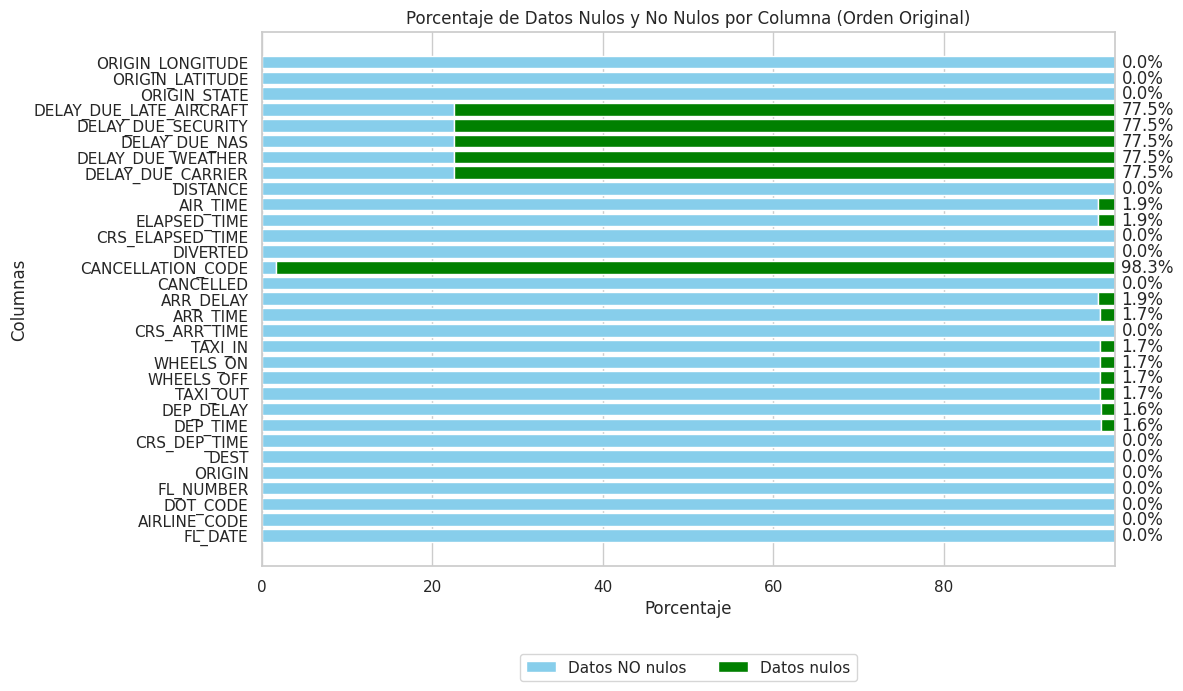

In [30]:
# Generamos un grafico que refleja el porcentaje de datos nulos por variable en color verde.

fig, ax = plt.subplots(figsize=(12, 8))

# Calcular porcentajes de datos nulos y no nulos

info_table['% Datos NO nulos'] = (info_table['Datos NO nulos'] / (info_table['Datos NO nulos'] + info_table['Datos nulos'])) * 100
info_table['% Datos nulos'] = (info_table['Datos nulos'] / (info_table['Datos NO nulos'] + info_table['Datos nulos'])) * 100

# Graficar datos no nulos (azul)
bars_non_null = ax.barh(info_table['Nombre de columna'], info_table['% Datos NO nulos'], color='skyblue', label='Datos NO nulos')

# Graficar datos nulos (verde) apilados sobre los no nulos
bars_null = ax.barh(info_table['Nombre de columna'], info_table['% Datos nulos'], left=info_table['% Datos NO nulos'], color='green', label='Datos nulos')

# Añadir etiquetas y título
ax.set_xlabel('Porcentaje')
ax.set_ylabel('Columnas')
ax.set_title('Porcentaje de Datos Nulos y No Nulos por Columna (Orden Original)')

# Colocar la leyenda debajo del gráfico
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

for bar, percentage in zip(bars_null, info_table['% Datos nulos']):
    width = bar.get_width()
    ax.annotate(f'{percentage:.1f}%',
                xy=(bar.get_x() + width, bar.get_y() + bar.get_height()/2),
                xytext=(5, 0),  # 5 points horizontal offset
                textcoords="offset points",
                ha='left', va='center')

# Mostrar el gráfico
plt.tight_layout(rect=[0, 0.1, 1, 1]) # Ajustar el diseño para evitar que las etiquetas se solapen y dejar espacio para la leyenda
plt.show()


#### 4.6.1  CANCELLATION CODE:

In [31]:
# Calcularemos cuantos registros tienen el campo 'CANCELLED' = 1 (es decir, el vuelo fue cancelado) y
# y el campo 'CANCELLATION_CODE' = NaN (es decir es nulo)

# Filtrar registros donde 'CANCELLED' es 1 y 'CANCELLATION_CODE' es nulo
canceled_and_null_code = df1[(df1['CANCELLED'] == 1) & (df1['CANCELLATION_CODE'].isnull())]

# Calcular el número de registros que cumplen la condición
num_registros = canceled_and_null_code.shape[0]

print(f"Cantidad de registros con CANCELLED = 1 y CANCELLATION_CODE = NaN: {num_registros}")

Cantidad de registros con CANCELLED = 1 y CANCELLATION_CODE = NaN: 0


No hay ningun registro que cumpla ambas condiciones, y por lo tanto, no es un problema que el campo CANCELLATION_CODE tenga tan alto porcentaje de nulos.

#### 4.6.2 Variables hasta un 1,9% de nulos

Las variables DEP_TIME, DEP_DELAY, ARR_TIME, ARR_DELAY, TAXI_OUT, WHEELS_OFF, WHEELS_ON, TAXI_IN, ELAPSED_TIME Y AIR_TIME se tratan de variables expresadas en minutos cuyo valor de nulos totales varia en 1,6% y 1,9% (es decir, porcentages bajos respecto al total).

Para todas estas variables, se analizara el reemplazo mediante la media, mediana y moda y evaluara el impacto en las variables estadisticas descriptivas principales:

'DEP_TIME', 'DEP_DELAY', 'ARR_TIME', , 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'ELAPSED_TIME', 'AIR_TIME'

##### 4.6.2.1 ARR_DELAY

In [26]:
# Se procede a reemplazar los ARR_DELAY nulos por la media, mediana y moda del mismo fl_number en 3 dataframe diferentes
# y calcula los describe para cada uno para comparar el resultado de cada alternativa. los casos que no tengan otro
# fl_number, reemplazar por la media, mediana y moda del dataframe general

print("Describe del DataFrame con ARR_DELAY sin rellenar los datos NaN (por vuelo y global):")
print(df1['ARR_DELAY'].describe().T.to_string())

# Reemplazamos los NaN en ARR_DELAY con la media para cada FL_NUMBER

# Creamos una copia del dataframe original para no modificarlo
df1_mean = df1.copy()

# Calculamos la media de ARR_DELAY para cada FL_NUMBER
mean_arr_delay_by_flight = df1_mean.groupby('FL_NUMBER')['ARR_DELAY'].transform('mean')

# Calculamos la media global de ARR_DELAY
global_mean_arr_delay = df1_mean['ARR_DELAY'].mean()

# Rellenamos los NaN en ARR_DELAY primero con la media por FL_NUMBER
df1_mean['ARR_DELAY'] = df1_mean['ARR_DELAY'].fillna(mean_arr_delay_by_flight)

# Luego, rellenamos los NaN restantes (donde el FL_NUMBER no tenía otros registros) con la media global
df1_mean['ARR_DELAY'] = df1_mean['ARR_DELAY'].fillna(global_mean_arr_delay)

print("\nDescribe del DataFrame con ARR_DELAY rellenado con la media (por vuelo y global):")
print(df1_mean['ARR_DELAY'].describe().T.to_string())

# Reemplazamos los NaN en ARR_DELAY con la mediana para cada FL_NUMBER

# Creamos una copia del dataframe original
df1_median = df1.copy()

# Calculamos la mediana de ARR_DELAY para cada FL_NUMBER
median_arr_delay_by_flight = df1_median.groupby('FL_NUMBER')['ARR_DELAY'].transform('median')

# Calculamos la mediana global de ARR_DELAY
global_median_arr_delay = df1_median['ARR_DELAY'].median()

# Rellenamos los NaN en ARR_DELAY primero con la mediana por FL_NUMBER
df1_median['ARR_DELAY'] = df1_median['ARR_DELAY'].fillna(median_arr_delay_by_flight)

# Luego, rellenamos los NaN restantes con la mediana global
df1_median['ARR_DELAY'] = df1_median['ARR_DELAY'].fillna(global_median_arr_delay)

print("\nDescribe del DataFrame con ARR_DELAY rellenado con la mediana (por vuelo y global):")
print(df1_median['ARR_DELAY'].describe().T.to_string())


# Reemplazamos los NaN en ARR_DELAY con la moda para cada FL_NUMBER

# Creamos una copia del dataframe original
df1_mode = df1.copy()

# Calculamos la moda de ARR_DELAY para cada FL_NUMBER
# Como `mode()` puede devolver múltiples valores o estar vacío, usamos el primer valor (si existe) o NaN
mode_arr_delay_by_flight = df1_mode.groupby('FL_NUMBER')['ARR_DELAY'].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan)

# Calculamos la moda global de ARR_DELAY
# Hacemos lo mismo que para la moda por grupo
global_mode_arr_delay = df1_mode['ARR_DELAY'].mode()[0] if not df1_mode['ARR_DELAY'].mode().empty else np.nan

# Rellenamos los NaN en ARR_DELAY primero con la moda por FL_NUMBER
df1_mode['ARR_DELAY'] = df1_mode['ARR_DELAY'].fillna(mode_arr_delay_by_flight)

# Luego, rellenamos los NaN restantes con la moda global
df1_mode['ARR_DELAY'] = df1_mode['ARR_DELAY'].fillna(global_mode_arr_delay)

print("\nDescribe del DataFrame con ARR_DELAY rellenado con la moda (por vuelo y global):")
print(df1_mode['ARR_DELAY'].describe().T.to_string())

Describe del DataFrame con ARR_DELAY sin rellenar los datos NaN (por vuelo y global):
count   4457159.00
mean          9.28
std          60.71
min        -119.00
25%         -14.00
50%          -5.00
75%          12.00
max        4405.00

Describe del DataFrame con ARR_DELAY rellenado con la media (por vuelo y global):
count   4545422.00
mean          9.29
std          60.12
min        -119.00
25%         -14.00
50%          -4.00
75%          12.00
max        4405.00

Describe del DataFrame con ARR_DELAY rellenado con la mediana (por vuelo y global):
count   4545422.00
mean          9.02
std          60.15
min        -119.00
25%         -14.00
50%          -5.00
75%          11.00
max        4405.00

Describe del DataFrame con ARR_DELAY rellenado con la moda (por vuelo y global):
count   4545422.00
mean          8.89
std          60.18
min        -119.00
25%         -14.00
50%          -5.00
75%          11.00
max        4405.00


Se selecciona el dataframe con los ARR_DELAY reemplazados por la media considerando es el que menos distorsionada los valores estadisticos del dataframe una vez reemplazados los datos faltantes.

In [27]:
# primero borramos los 3 df para evitar colab se cierre por memoria RAM.

del df1_mean, df1_median, df1_mode


In [28]:
# Se procede a reemplazar cada valor nulo de ARR_DELAY por el promedio de cada FL_NUMBER.
# Caso no tenga FL_NUMBER, se reemplaza por el promedio general.

# Se selecciona el dataframe con los ARR_DELAY reemplazados por la media

# Calculamos la media de ARR_DELAY para cada FL_NUMBER
mean_arr_delay_by_flight = df1.groupby('FL_NUMBER')['ARR_DELAY'].transform('mean')

# Calculamos la media global de ARR_DELAY
global_mean_arr_delay = df1['ARR_DELAY'].mean()

# Rellenamos los NaN en ARR_DELAY primero con la media por FL_NUMBER
df1['ARR_DELAY'] = df1['ARR_DELAY'].fillna(mean_arr_delay_by_flight)

# Luego, rellenamos los NaN restantes (donde el FL_NUMBER no tenía otros registros) con la media global
df1['ARR_DELAY'] = df1['ARR_DELAY'].fillna(global_mean_arr_delay)

print("\nDescribe del DataFrame final con ARR_DELAY rellenado con la media:")
print(df1['ARR_DELAY'].describe().T.to_string())



Describe del DataFrame final con ARR_DELAY rellenado con la media:
count   4545422.00
mean          9.29
std          60.12
min        -119.00
25%         -14.00
50%          -4.00
75%          12.00
max        4405.00


##### 4.6.2.2 RESTO DE LAS VARIABLES

Dado que el porcentaje de nulos sobre el total es reducido, inferimos que el compartiento para el resto de las variables con menos del 2% de nulos y que expresan una unidad de temporalidad (minutos), procedemos a reemplazar dichos nulos por la media (tomando como valido el test anterior).

In [29]:
# Se reemplaza los valores nulos de las variables 'DEP_TIME', 'DEP_DELAY', 'ARR_TIME', , 'TAXI_OUT', 'WHEELS_OFF',
# 'WHEELS_ON', 'TAXI_IN','ELAPSED_TIME' y 'AIR_TIME' por el promedio/media de cada variable con mismo FL_NUMBER.
# En caso de no tener FL_NUMBER se toma promedio de la variable general.

# Lista de columnas a imputar
cols_to_impute = ['DEP_TIME', 'DEP_DELAY', 'ARR_TIME', 'TAXI_OUT',
                  'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'ELAPSED_TIME', 'AIR_TIME']

for col in cols_to_impute:
    print(f"\nProcesando columna: {col}")
    print(f"Describe antes de imputación para {col}:")
    print(df1[col].describe().T.to_string())

    # Calcular la media del grupo 'FL_NUMBER' para la columna actual
    mean_by_flight = df1.groupby('FL_NUMBER')[col].transform('mean')

    # Calcular la media global de la columna actual
    global_mean = df1[col].mean()

    # Rellenar los NaN primero con la media por FL_NUMBER
    df1[col] = df1[col].fillna(mean_by_flight)

    # Luego, rellenar los NaN restantes con la media global
    df1[col] = df1[col].fillna(global_mean)

    print(f"Describe después de imputación para {col} (media por vuelo y global):")
    print(df1[col].describe().T.to_string())

print("\nProceso de imputación completado.")

# Verificamos la cantidad de nulos después de la imputación para las columnas
print("\nCantidad de nulos después de la imputación:")
print(df1[cols_to_impute].isnull().sum())



Procesando columna: DEP_TIME
Describe antes de imputación para DEP_TIME:
count   4472532.00
mean       1336.98
std         516.41
min           1.00
25%         909.00
50%        1327.00
75%        1753.00
max        2400.00
Describe después de imputación para DEP_TIME (media por vuelo y global):
count   4545422.00
mean       1337.25
std         512.81
min           1.00
25%         914.00
50%        1328.00
75%        1750.00
max        2400.00

Procesando columna: DEP_DELAY
Describe antes de imputación para DEP_DELAY:
count   4472502.00
mean         14.41
std          58.92
min         -68.00
25%          -5.00
50%          -1.00
75%          12.00
max        4413.00
Describe después de imputación para DEP_DELAY (media por vuelo y global):
count   4545422.00
mean         14.41
std          58.45
min         -68.00
25%          -5.00
50%          -1.00
75%          12.09
max        4413.00

Procesando columna: ARR_TIME
Describe antes de imputación para ARR_TIME:
count   4468546.00
me

#### 4.6.3 DELAY_DUE_XXX:

In [21]:
# Calcularemos cuantos registros tienen:
# ARR_DELAY >= 0 y la suma de los DELAY_DUE_XXX es igual a ARR_DELAY (estaria OK).
# ARR_DELAY >= 0 y la suma de los DELAY_DUE_XXX NO es igual a ARR_DELAY (NO estaria OK).
# ARR_DELAY < 0 y la suma de los DELAY_DUE_XXX es igual a 0 (estaria OK).
# No entra en ninguno de los 3 grupos anteriores.

# Filtrar registros donde ARR_DELAY >= 0 y la suma de los DELAY_DUE_X es igual a ARR_DELAY
condition_equal_delay = (df1['ARR_DELAY'] >= 0) & \
                        (df1['ARR_DELAY'] == df1[['DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT']].sum(axis=1))

# Filtrar registros donde ARR_DELAY >= 0 y la suma de los DELAY_DUE_X es diferente a ARR_DELAY
condition_not_equal_delay = (df1['ARR_DELAY'] >= 0) & \
                            (df1['ARR_DELAY'] != df1[['DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT']].sum(axis=1))

# Filtrar registros donde ARR_DELAY < 0 y la suma de los DELAY_DUE_X es 0 o nulo
# Para verificar si la suma es 0 o nula, primero sumamos y luego verificamos si el resultado es 0 o NaN
delay_due_sum = df1[['DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT']].sum(axis=1)
condition_negative_arr_delay = (df1['ARR_DELAY'] < 0) & \
                               ((delay_due_sum == 0) | (delay_due_sum.isnull()))

# Los restantes son aquellos que no cumplen ninguna de las condiciones anteriores
condition_remaining = ~(condition_equal_delay | condition_not_equal_delay | condition_negative_arr_delay)

# Contar los registros en cada grupo
count_equal_delay = df1[condition_equal_delay].shape[0]
count_not_equal_delay = df1[condition_not_equal_delay].shape[0]
count_negative_arr_delay = df1[condition_negative_arr_delay].shape[0]
count_remaining = df1[condition_remaining].shape[0]

print(f"Registros donde ARR_DELAY >= 0 y ARR_DELAY == Suma de DELAY_DUE_X (OK):  {count_equal_delay}")
print(f"Registros donde ARR_DELAY >= 0 y ARR_DELAY no es igual a Suma de DELAY_DUE_X (NO OK): {count_not_equal_delay}")
print(f"Registros donde ARR_DELAY < 0 y Suma de DELAY_DUE_X es 0 o nula (OK): {count_negative_arr_delay}")
print(f"Registros restantes (no en ningún grupo anterior): {count_remaining}")

# Verificar la suma total de registros
total_counted = count_equal_delay + count_not_equal_delay + count_negative_arr_delay + count_remaining
total_df = df1.shape[0]
print('')
print(f"Total de registros contados en los grupos: {total_counted}")
print(f"Total de registros en el DataFrame: {total_df}")

Registros donde ARR_DELAY >= 0 y ARR_DELAY == Suma de DELAY_DUE_X (OK):  1106841
Registros donde ARR_DELAY >= 0 y ARR_DELAY no es igual a Suma de DELAY_DUE_X (NO OK): 818923
Registros donde ARR_DELAY < 0 y Suma de DELAY_DUE_X es 0 o nula (OK): 2624025
Registros restantes (no en ningún grupo anterior): 0

Total de registros contados en los grupos: 4549789
Total de registros en el DataFrame: 4549789


In [37]:
# Calculamos cuantos registros ARR_DELAY >0 y Suma de DELAY_DUE_X = 0 o NaN (los no OK)

# Contar registros donde ARR_DELAY > 0 y la suma de DELAY_DUE_X es 0 o NaN
# Primero, calculamos la suma de las columnas DELAY_DUE_X
delay_due_sum = df1[['DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT']].sum(axis=1)

# Filtramos los registros que cumplen la condición
condition_arr_delay_positive_sum_zero_or_nan = (df1['ARR_DELAY'] > 0) & ((delay_due_sum == 0) | (delay_due_sum.isnull()))

# Contamos el número de registros que cumplen la condición
count_arr_delay_positive_sum_zero_or_nan = df1[condition_arr_delay_positive_sum_zero_or_nan].shape[0]

print(f"Cantidad de registros con ARR_DELAY > 0 y Suma de DELAY_DUE_X = 0 o NaN (NO OK): {count_arr_delay_positive_sum_zero_or_nan}")


Cantidad de registros con ARR_DELAY > 0 y Suma de DELAY_DUE_X = 0 o NaN (NO OK): 818233


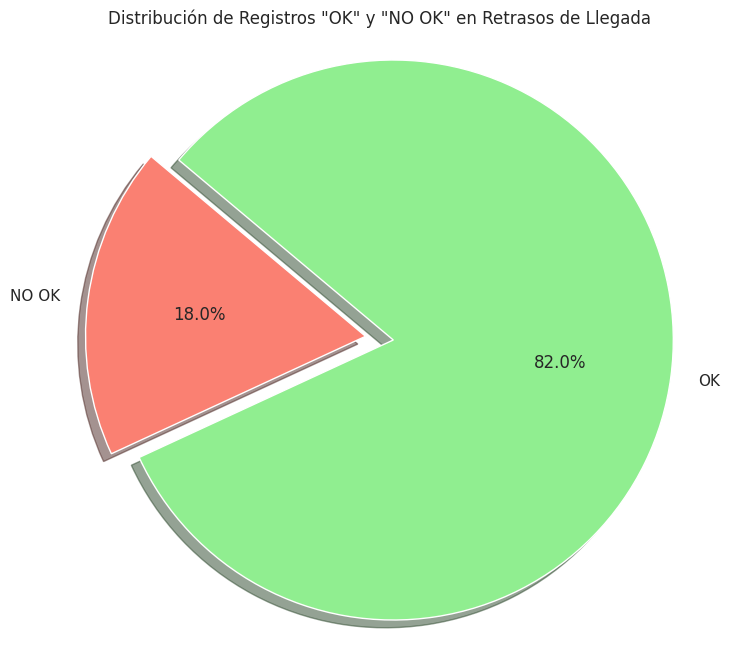

In [38]:
# Realizamos grafico de torta con los valores OK y NO OK para las variables DELAY_DUE_XXX
# Estas son: 'DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT'

# NOTA: No esta OK cuando la variable ARR_DELAY > 0 (es decir, el avion aterrizo demorado) y la suma de estas variables
# Da 0 o Nan

# Contamos los registros "OK" restando los "NO OK" del total
count_ok = total_df - count_arr_delay_positive_sum_zero_or_nan

# Creamos una serie de Pandas con los counts y etiquetas
sizes = [count_arr_delay_positive_sum_zero_or_nan, count_ok]
labels = ['NO OK', 'OK']
colors = ['salmon', 'lightgreen']
explode = (0.1, 0)  # "Explota" el primer slice (NO OK) un poco

# Crear el gráfico de torta
plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=140)

plt.title('Distribución de Registros "OK" y "NO OK" en Retrasos de Llegada')
plt.axis('equal')  # Asegura que el círculo sea dibujado como un círculo.

plt.show()


Si bien en torno al 77,48% de los datos es nulo, solo el 18% es nulo incorrectamente. Pues muchos datos son nulos cuando el avion no ha llegado/aterrizado tardiamente ARR_DELAY <= 0. En cambio, solo en el 18% de los datos/registros, tenemos que ARR_DELAY > 0 y estas variables son cero o nulas.

In [39]:
# Completamos los NaN de DELAY DUE XX cuando ARR_DELAY > 0 con el promedio, mediana y media de cada variable general.
# Realizar un describe antes y despues de completar. Esto ultimo realizarlo sobre DF provisorio y eliminarlos luego.

# Crear un DataFrame provisorio para el análisis
df_provisorio = df1.copy()

# Seleccionar las columnas DELAY_DUE_XX
delay_due_cols = ['DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT']

# Filtrar solo las filas donde ARR_DELAY > 0 y hay NaN en las columnas DELAY_DUE_XX
# No es necesario filtrar por NaN en todas, ya que la consigna es completar los NaN
# cuando ARR_DELAY > 0.
# Sin embargo, para el análisis de Describe antes, lo haremos sobre todo el df_provisorio
# para ver el impacto general.

print("Describe de las variables DELAY_DUE_XX antes de completar los NaN (en todo el DataFrame):")
print(df_provisorio[delay_due_cols].describe().T.to_string())

# Identificar las filas donde ARR_DELAY > 0
filas_con_demora_llegada = df_provisorio['ARR_DELAY'] > 0

# Calcular la media, mediana y moda general para cada columna DELAY_DUE_XX
# Se excluyen los NaN al calcular estas estadísticas
medias_generales = df_provisorio[delay_due_cols].mean()
medianas_generales = df_provisorio[delay_due_cols].median()
modas_generales = df_provisorio[delay_due_cols].mode().iloc[0] # .mode() puede devolver múltiples, tomamos el primero

# Imputar los NaN en las filas con ARR_DELAY > 0 usando las estadísticas generales
# Usando .loc para asegurarnos de modificar el DataFrame provisorio y solo las filas relevantes
for col in delay_due_cols:
    # Rellenar NaN en la columna actual, solo para las filas donde ARR_DELAY > 0
    # Opción 1: Rellenar con la media general
    # df_provisorio.loc[filas_con_demora_llegada, col] = df_provisorio.loc[filas_con_demora_llegada, col].fillna(medias_generales[col])

    # Opción 2: Rellenar con la mediana general
    # df_provisorio.loc[filas_con_demora_llegada, col] = df_provisorio.loc[filas_con_demora_llegada, col].fillna(medianas_generales[col])

    # Opción 3: Rellenar con la moda general
    df_provisorio.loc[filas_con_demora_llegada, col] = df_provisorio.loc[filas_con_demora_llegada, col].fillna(modas_generales[col])

print("\n--- Análisis comparativo de Describe con diferentes imputaciones (DF provisorio) ---")

# Describe con imputación por Media general
df_temp_mean = df1.copy() # Usar copia del df original para cada test
filas_con_demora_llegada_temp = df_temp_mean['ARR_DELAY'] > 0
for col in delay_due_cols:
     df_temp_mean.loc[filas_con_demora_llegada_temp, col] = df_temp_mean.loc[filas_con_demora_llegada_temp, col].fillna(medias_generales[col])
print("\nDescribe con imputación por Media general:")
print(df_temp_mean[delay_due_cols].describe().T.to_string())
del df_temp_mean # Eliminar df temporal

# Describe con imputación por Mediana general
df_temp_median = df1.copy() # Usar copia del df original para cada test
filas_con_demora_llegada_temp = df_temp_median['ARR_DELAY'] > 0
for col in delay_due_cols:
     df_temp_median.loc[filas_con_demora_llegada_temp, col] = df_temp_median.loc[filas_con_demora_llegada_temp, col].fillna(medianas_generales[col])
print("\nDescribe con imputación por Mediana general:")
print(df_temp_median[delay_due_cols].describe().T.to_string())
del df_temp_median # Eliminar df temporal

# Describe con imputación por Moda general
df_temp_mode = df1.copy() # Usar copia del df original para cada test
filas_con_demora_llegada_temp = df_temp_mode['ARR_DELAY'] > 0
for col in delay_due_cols:
     df_temp_mode.loc[filas_con_demora_llegada_temp, col] = df_temp_mode.loc[filas_con_demora_llegada_temp, col].fillna(modas_generales[col])
print("\nDescribe con imputación por Moda general:")
print(df_temp_mode[delay_due_cols].describe().T.to_string())
del df_temp_mode # Eliminar df temporal


# Eliminar el DataFrame provisorio al final del análisis comparativo
# Si solo se usó para los describes temporales, ya fueron eliminados (df_temp_*)
# Si se realizó una imputación real en df_provisorio, se elimina aquí:
del df_provisorio
print("\nDataFrame provisorio eliminado.")


Describe de las variables DELAY_DUE_XX antes de completar los NaN (en todo el DataFrame):
                             count  mean   std  min  25%  50%   75%     max
DELAY_DUE_CARRIER       1023514.00 25.22 77.64 0.00 0.00 4.00 23.00 3957.00
DELAY_DUE_WEATHER       1023514.00  3.81 31.49 0.00 0.00 0.00  0.00 1747.00
DELAY_DUE_NAS           1023514.00 12.99 32.29 0.00 0.00 0.00 16.00 1708.00
DELAY_DUE_SECURITY      1023514.00  0.14  3.73 0.00 0.00 0.00  0.00 1460.00
DELAY_DUE_LATE_AIRCRAFT 1023514.00 28.63 63.65 0.00 0.00 4.00 33.00 3581.00

--- Análisis comparativo de Describe con diferentes imputaciones (DF provisorio) ---

Describe con imputación por Media general:
                             count  mean   std  min  25%   50%   75%     max
DELAY_DUE_CARRIER       1841747.00 25.22 57.88 0.00 2.00 25.22 25.22 3957.00
DELAY_DUE_WEATHER       1841747.00  3.81 23.47 0.00 0.00  0.00  3.81 1747.00
DELAY_DUE_NAS           1841747.00 12.99 24.07 0.00 0.00 12.99 12.99 1708.00
DELAY_DUE_SECURI

In [40]:
# Generamos un df provisorio donde los DELAY_DUE_XX sean reemplazados por la media de cada variable cuando ARR_DELAY > 0
# y DELAY_DUE XX = 0

# Creamos un DataFrame provisorio para el análisis
df_provisorio = df1.copy()

# Seleccionamos las columnas DELAY_DUE_XX
delay_due_cols = ['DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT']

print("Describe de las variables DELAY_DUE_XX antes de completar los NaN (en todo el DataFrame):")
print(df_provisorio[delay_due_cols].describe().T.to_string())

# Identificamos las filas donde ARR_DELAY > 0
filas_con_demora_llegada = df_provisorio['ARR_DELAY'] > 0

# Calculamos la media general para cada columna DELAY_DUE_XX
# Se excluyen los NaN al calcular estas estadísticas
medias_generales = df_provisorio[delay_due_cols].mean()

print("\n--- Describe con imputación por Media general (DF provisorio) ---")

# Imputar los NaN en las filas con ARR_DELAY > 0 usando la media general
# Usando .loc para asegurarnos de modificar el DataFrame provisorio y solo las filas relevantes
for col in delay_due_cols:
    # Rellenar NaN en la columna actual, solo para las filas donde ARR_DELAY > 0
    df_provisorio.loc[filas_con_demora_llegada, col] = df_provisorio.loc[filas_con_demora_llegada, col].fillna(medias_generales[col])

# Mostrar el describe del DataFrame provisorio después de la imputación con la media
print(df_provisorio[delay_due_cols].describe().T.to_string())

# Nota: Este DataFrame df_provisorio ahora contiene los NaN en las columnas DELAY_DUE_XX
# para las filas donde ARR_DELAY > 0 reemplazados por la media general de cada columna.

# Opcional: Verificar cuántos nulos quedan en las columnas DELAY_DUE_XX en las filas con ARR_DELAY > 0
# (Deberían ser 0 si la imputación funcionó correctamente para esas filas)
print("\nVerificación de nulos en DELAY_DUE_XX en filas con ARR_DELAY > 0 después de imputación:")
print(df_provisorio.loc[filas_con_demora_llegada, delay_due_cols].isnull().sum())


Describe de las variables DELAY_DUE_XX antes de completar los NaN (en todo el DataFrame):
                             count  mean   std  min  25%  50%   75%     max
DELAY_DUE_CARRIER       1023514.00 25.22 77.64 0.00 0.00 4.00 23.00 3957.00
DELAY_DUE_WEATHER       1023514.00  3.81 31.49 0.00 0.00 0.00  0.00 1747.00
DELAY_DUE_NAS           1023514.00 12.99 32.29 0.00 0.00 0.00 16.00 1708.00
DELAY_DUE_SECURITY      1023514.00  0.14  3.73 0.00 0.00 0.00  0.00 1460.00
DELAY_DUE_LATE_AIRCRAFT 1023514.00 28.63 63.65 0.00 0.00 4.00 33.00 3581.00

--- Describe con imputación por Media general (DF provisorio) ---
                             count  mean   std  min  25%   50%   75%     max
DELAY_DUE_CARRIER       1841747.00 25.22 57.88 0.00 2.00 25.22 25.22 3957.00
DELAY_DUE_WEATHER       1841747.00  3.81 23.47 0.00 0.00  0.00  3.81 1747.00
DELAY_DUE_NAS           1841747.00 12.99 24.07 0.00 0.00 12.99 12.99 1708.00
DELAY_DUE_SECURITY      1841747.00  0.14  2.78 0.00 0.00  0.00  0.14 1460.00
DE

In [41]:
# Verificamos en cuantos registros de df_provisorio ARR_DELAY>0 y suma de DELAY_DUE_XX no es igual a ARR_DELAY.

# Seleccionar las columnas DELAY_DUE_XX
delay_due_cols = ['DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT']

# Crear una columna para la suma de los DELAY_DUE_XX. Rellenar NaN con 0 para la suma.
# Esto asume que un NaN en una columna DELAY_DUE_XX significa 0 demora por ese motivo.
# Se crea una copia temporal de las columnas para no modificar el df_provisorio si no se desea
df_temp_delay_due = df_provisorio[delay_due_cols].fillna(0)
df_provisorio['SUM_DELAY_DUE_XX'] = df_temp_delay_due.sum(axis=1)

# Filtrar los registros donde ARR_DELAY > 0
df_demorados = df_provisorio[df_provisorio['ARR_DELAY'] > 0].copy()

# Contar los registros donde ARR_DELAY > 0 y SUM_DELAY_DUE_XX no es igual a ARR_DELAY
count_not_equal = df_demorados[df_demorados['SUM_DELAY_DUE_XX'] != df_demorados['ARR_DELAY']].shape[0]

print(f"Cantidad de registros en df_provisorio donde ARR_DELAY > 0 y SUM_DELAY_DUE_XX no es igual a ARR_DELAY: {count_not_equal}")

# Eliminar la columna temporal SUM_DELAY_DUE_XX si no se necesita más
del df_provisorio['SUM_DELAY_DUE_XX']


Cantidad de registros en df_provisorio donde ARR_DELAY > 0 y SUM_DELAY_DUE_XX no es igual a ARR_DELAY: 818233


Dado el elevado consumo de recurso computacional al intentar ejecutar los algoritmos propuestos y poca representatividad de completar los nulos (se evaluo con la media, mediana y moda de cada variable y se distorsiona considerablemente los valores estadisticos de cada uno con la mediana y moda, y no asi con la media. Pero al reemplazar con la media, notamos que no se cumple que ARR_DELAY = SUMA VARIABLES DUE_DELAY_XXX), **se propone no completar estos valores nulos**. Al analizar luego el motivo de la demora en minutos se debera definir si se dejan sin efecto las variables NO OK (o nulas) cuando ARR_DELAY > 0.

Nota: La complejidad computacional radica en que se deben completar los valores NaN por media, mediana y moda de cada variable pero ademas, la suma de todas las variables DELAY_DUE_XX (5 en total) deben ser = a ARR_DELAY. Al tratarse de 818.233 registros, esto genera un error en la ejecución para la versión disponible.

#### 4.6.4 Dataframe Df1 Resultante

In [30]:
# Analizamos nulos de df1 por cada variable

# Reflejamos a continuacion por columna/variable la cantidad de datos nulos y datos unicos.
# A su vez, se calcula y muestra el % de datos nulos (sobre el total de datos)

print(pd.DataFrame({
    'datos_nulos': df1.isnull().sum(),
    '%_nulos': (df1.isnull().sum() / len(df1) * 100).map('{:.2f}%'.format),
    'datos_unicos': df1.nunique(),
}))


                         datos_nulos %_nulos  datos_unicos
FL_DATE                            0   0.00%           243
AIRLINE_CODE                       0   0.00%            15
DOT_CODE                           0   0.00%            15
FL_NUMBER                          0   0.00%          6268
ORIGIN                             0   0.00%           349
DEST                               0   0.00%           349
CRS_DEP_TIME                       0   0.00%          1327
DEP_TIME                           0   0.00%          7197
DEP_DELAY                          0   0.00%          7527
TAXI_OUT                           0   0.00%          5921
WHEELS_OFF                         0   0.00%          7204
WHEELS_ON                          0   0.00%          7211
TAXI_IN                            0   0.00%          5925
CRS_ARR_TIME                       0   0.00%          1404
ARR_TIME                           0   0.00%          7204
ARR_DELAY                          0   0.00%          76

### 4.7 Evaluamos Outliers:

In [31]:
# Calculamos outliers por variable numerica ordenando por % de datos outliers.

def detect_outliers_iqr(df, column):
    """Detecta outliers en una columna numérica usando el método IQR."""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers.shape[0]

# Seleccionar solo las columnas numéricas
numeric_cols = df1.select_dtypes(include=np.number).columns.tolist()

# Columnas numéricas que tienen sentido para el análisis de outliers (excluyendo códigos, booleanos, etc.)
cols_to_check_outliers = [
    'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT',
    'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME',
    'ARR_TIME', 'ARR_DELAY', 'CRS_ELAPSED_TIME',
    'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
    'DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS',
    'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT',
    'ORIGIN_LATITUDE', 'ORIGIN_LONGITUDE'
]

# Asegurarse de que las columnas existen y son numéricas en el DataFrame actual
cols_to_check_outliers = [col for col in cols_to_check_outliers if col in numeric_cols]

outlier_counts = {}
total_records = len(df1)

for col in cols_to_check_outliers:
    count = detect_outliers_iqr(df1, col)
    outlier_counts[col] = count

# Crear un DataFrame con los resultados
outlier_df = pd.DataFrame(list(outlier_counts.items()), columns=['Variable', 'Cantidad_Outliers'])

# Calcular el porcentaje de outliers
outlier_df['Porcentaje_Outliers'] = (outlier_df['Cantidad_Outliers'] / total_records) * 100

# Ordenar por cantidad de outliers descendente
outlier_df = outlier_df.sort_values(by='Cantidad_Outliers', ascending=False)

# Formatear el porcentaje
outlier_df['Porcentaje_Outliers'] = outlier_df['Porcentaje_Outliers'].map('{:.2f}%'.format)

print("Cantidad de Outliers por Variable Numérica y % sobre el Total de Datos:")
print(outlier_df.to_string(index=False))

Cantidad de Outliers por Variable Numérica y % sobre el Total de Datos:
               Variable  Cantidad_Outliers Porcentaje_Outliers
              DEP_DELAY             552199              12.15%
              ARR_DELAY             415726               9.15%
                TAXI_IN             320036               7.04%
               DISTANCE             280802               6.18%
               TAXI_OUT             261418               5.75%
               AIR_TIME             241497               5.31%
       CRS_ELAPSED_TIME             239958               5.28%
           ELAPSED_TIME             229498               5.05%
      DELAY_DUE_CARRIER             104724               2.30%
DELAY_DUE_LATE_AIRCRAFT              98638               2.17%
        ORIGIN_LATITUDE              93146               2.05%
          DELAY_DUE_NAS              82965               1.83%
      DELAY_DUE_WEATHER              58064               1.28%
       ORIGIN_LONGITUDE              53699    

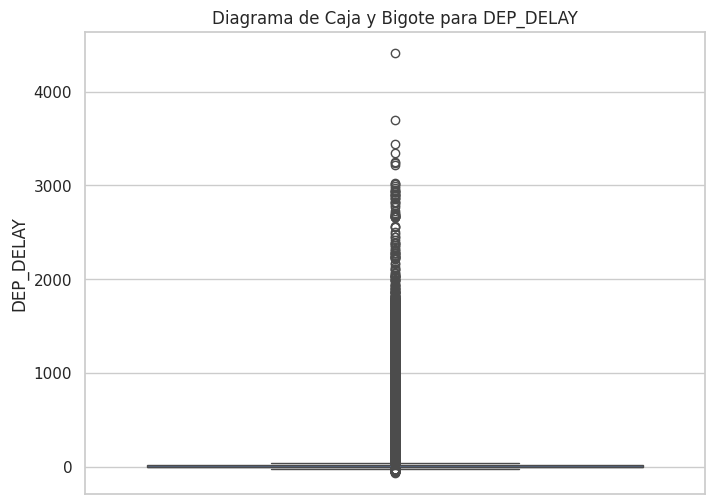

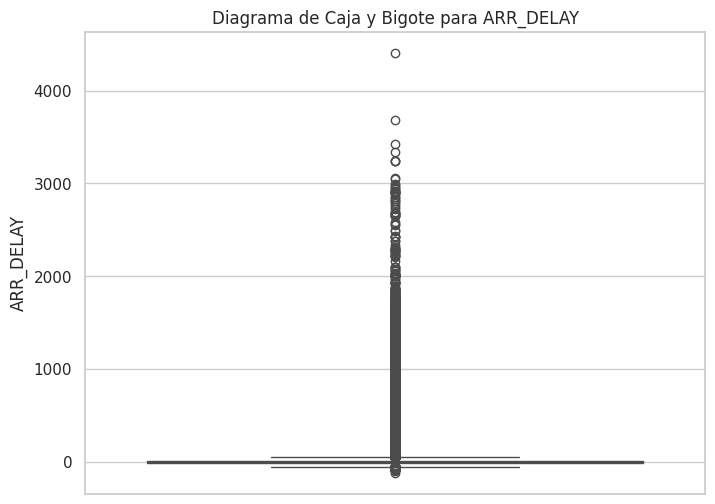

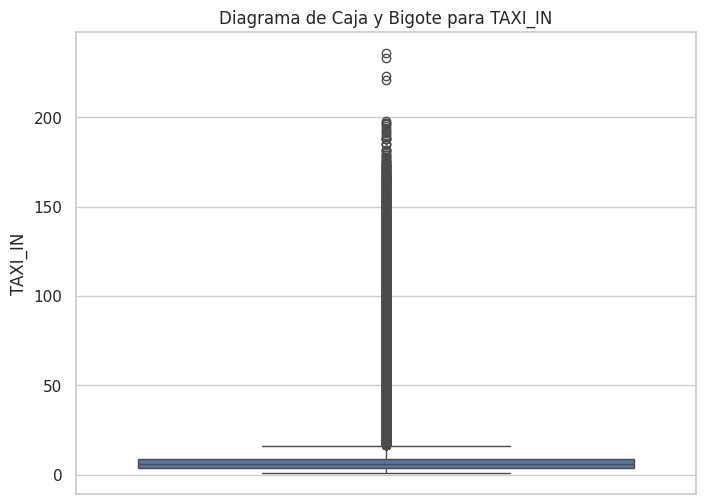

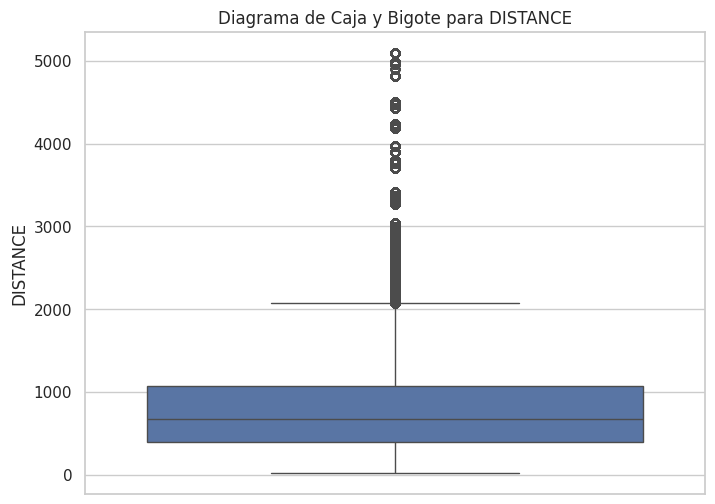

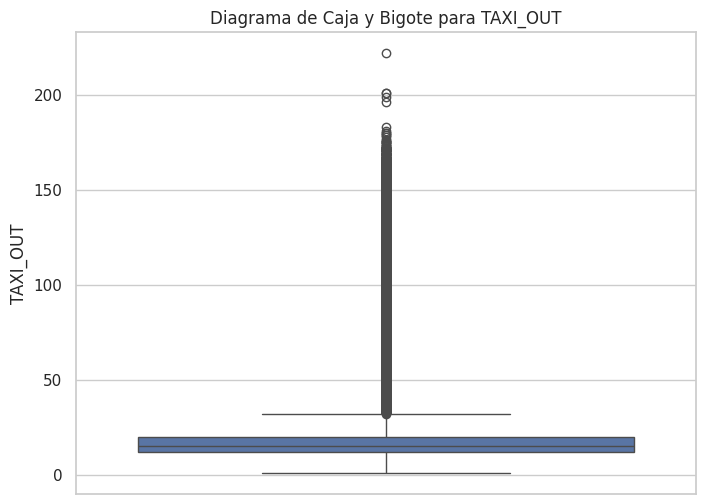

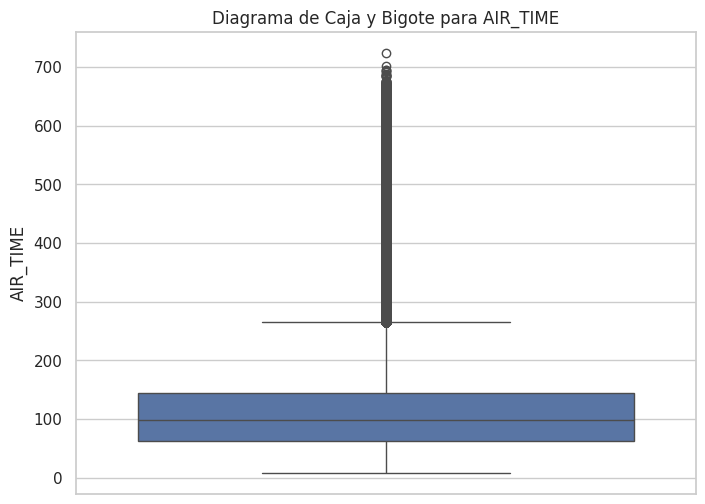

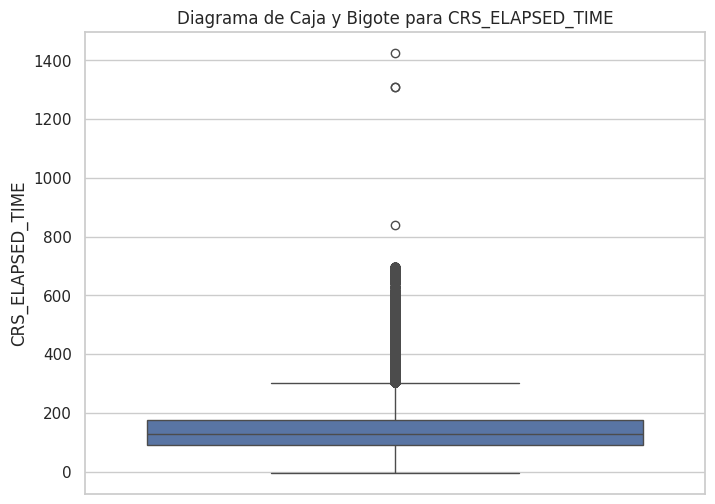

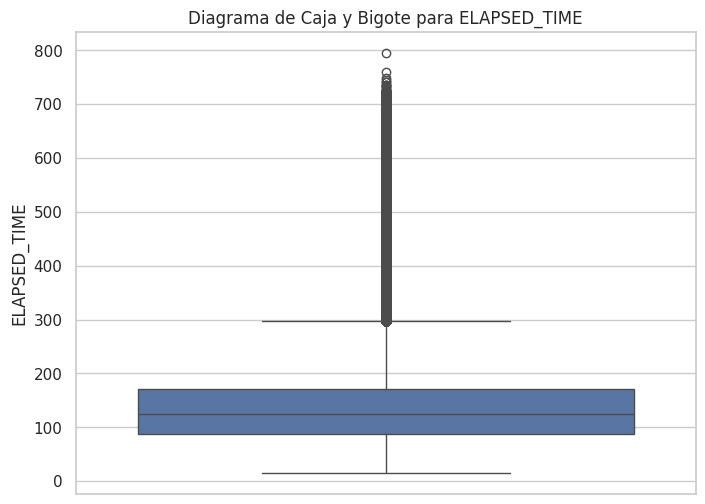

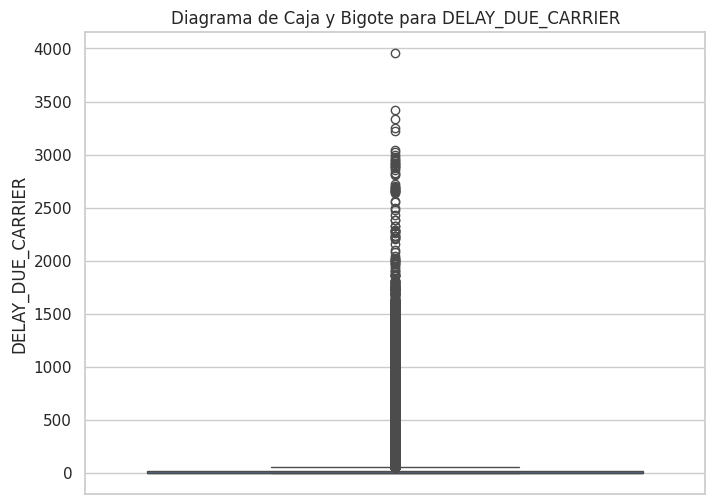

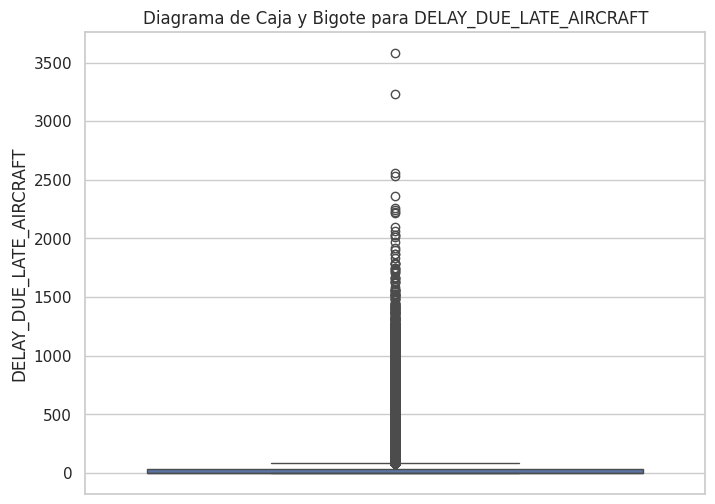

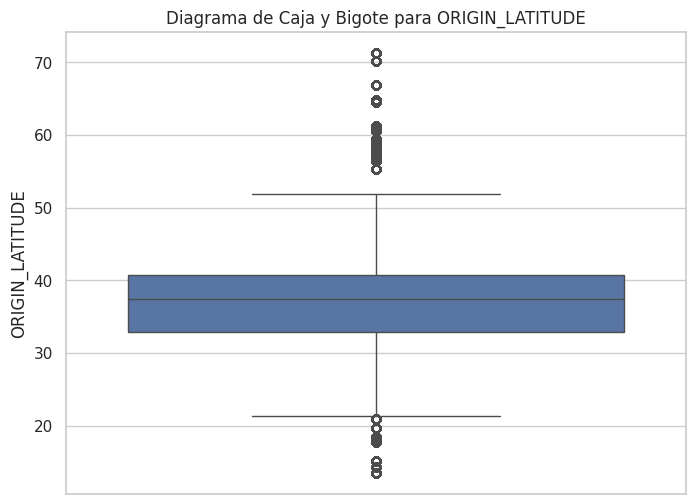

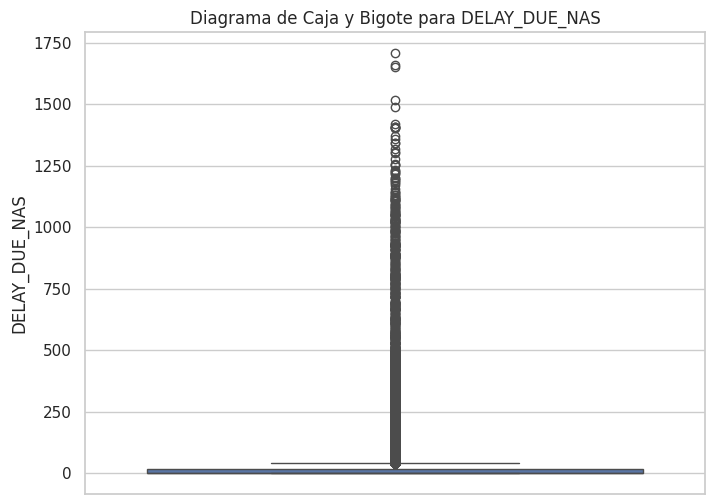

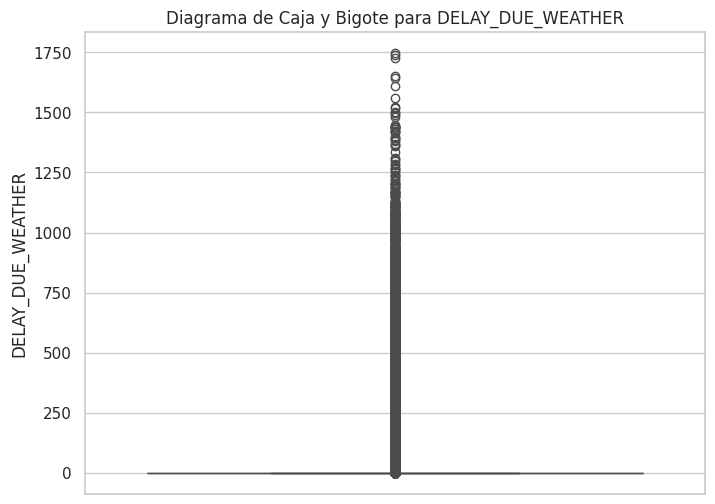

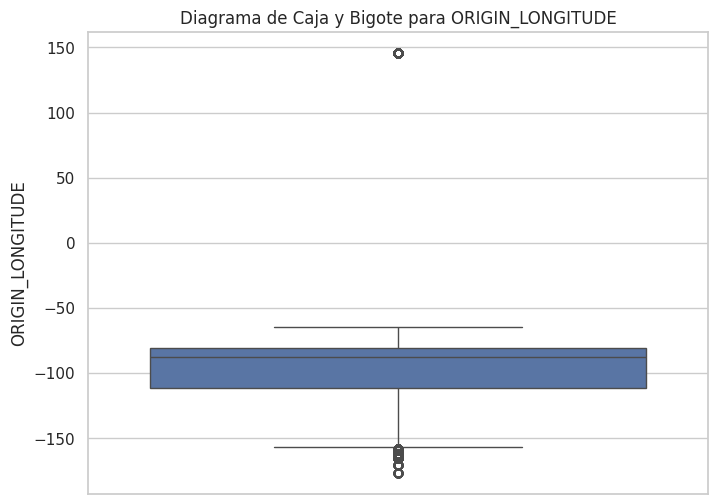

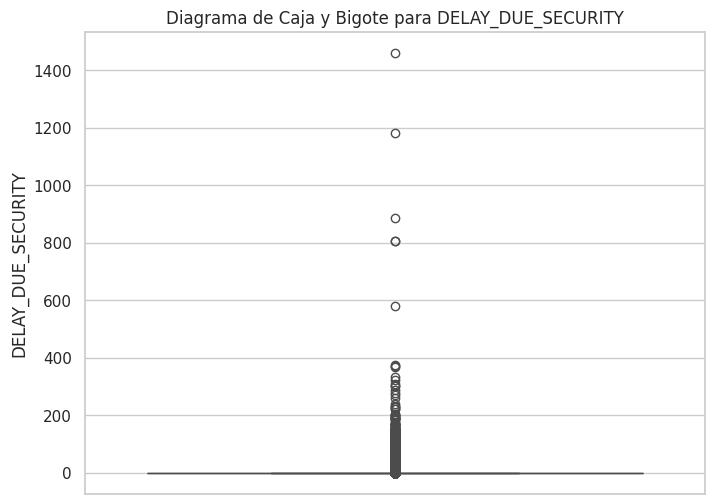

In [58]:
# Realizamos diagramas de caja y bigote vertical para las variables con outliers > 0%

# Filtrar las variables con un porcentaje de outliers mayor a 0%
variables_con_outliers_significativos = outlier_df[outlier_df['Cantidad_Outliers'] > 0]['Variable'].tolist()

# Crear diagramas de caja y bigote verticales para estas variables
for col in variables_con_outliers_significativos:
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=df1[col])
    plt.title(f'Diagrama de Caja y Bigote para {col}')
    plt.ylabel(col)
    plt.show()


Algunas conclusiones que podemos tomar son:

**Variables temporales (minutos):** Casi la totalidad de los outliers estan por encima del "bigote" superior.

**ORIGIN_LONGITUDE:** Casi la totalidad de los outliers estan por debajo del "bigote" inferior. Se tratan de las islas que son parte del pais EEUU al sur de las tierras del continente.

**ORIGIN_LATITUD:** Casi la totalidad de los outliers estan por encima del "bigote" superior. Se tratan de las islas que son parte del pais EEUU al sur de las tierras del continente.

In [32]:
# Reemplazamos en dataframe provisorio los outliers mayores a bigote superior por bigote superior y outliers
# menores a bigote inferior para variables con outliers mayores a 5%. Mostrar el describe de esas variables antes vs
# despues del reemplazo.

# Función para reemplazar outliers por los límites del bigote
def replace_outliers_with_bounds(df, column, lower_bound, upper_bound):
  """Reemplaza los outliers en una columna por los límites del bigote."""
  df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
  df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
  return df

# Crear un DataFrame provisorio para aplicar los reemplazos y comparar
df_provisorio_outliers = df1.copy()

# Identificar las variables con porcentaje de outliers > 5%
variables_con_outliers_mayor_5 = outlier_df[outlier_df['Porcentaje_Outliers'].str.replace('%','').astype(float) > 5]['Variable'].tolist()

print("Variables con outliers > 5%:")
print(variables_con_outliers_mayor_5)

# Iterar sobre las variables identificadas para reemplazar outliers
for col in variables_con_outliers_mayor_5:
  print(f"\nProcesando columna: {col}")

  # Mostrar describe antes del reemplazo
  print(f"\nDescribe de '{col}' ANTES del reemplazo de outliers:")
  print(df_provisorio_outliers[col].describe().T.to_string())

  # Calcular los límites del bigote (IQR)
  Q1 = df_provisorio_outliers[col].quantile(0.25)
  Q3 = df_provisorio_outliers[col].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  print(f"Límite inferior del bigote para '{col}': {lower_bound:.2f}")
  print(f"Límite superior del bigote para '{col}': {upper_bound:.2f}")


  # Reemplazar outliers
  df_provisorio_outliers = replace_outliers_with_bounds(df_provisorio_outliers, col, lower_bound, upper_bound)

  # Mostrar describe después del reemplazo
  print(f"\nDescribe de '{col}' DESPUÉS del reemplazo de outliers:")
  print(df_provisorio_outliers[col].describe().T.to_string())

# El DataFrame df_provisorio_outliers ahora contiene los outliers reemplazados
# solo para las columnas que tenían más del 5% de outliers.

# Puedes verificar si hay outliers restantes en esas columnas después del reemplazo (deberían ser 0)
print("\nVerificación de outliers en columnas procesadas después del reemplazo:")
outlier_counts_after = {}
for col in variables_con_outliers_mayor_5:
     count = detect_outliers_iqr(df_provisorio_outliers, col)
     outlier_counts_after[col] = count

outlier_df_after = pd.DataFrame(list(outlier_counts_after.items()), columns=['Variable', 'Cantidad_Outliers_Despues'])
print(outlier_df_after.to_string(index=False))

# Eliminar el DataFrame provisorio si no se necesita más
# del df_provisorio_outliers # Descomentar si se quiere liberar memoria RAM

Variables con outliers > 5%:
['DEP_DELAY', 'ARR_DELAY', 'TAXI_IN', 'DISTANCE', 'TAXI_OUT', 'AIR_TIME', 'CRS_ELAPSED_TIME', 'ELAPSED_TIME']

Procesando columna: DEP_DELAY

Describe de 'DEP_DELAY' ANTES del reemplazo de outliers:
count   4545422.00
mean         14.41
std          58.45
min         -68.00
25%          -5.00
50%          -1.00
75%          12.09
max        4413.00
Límite inferior del bigote para 'DEP_DELAY': -30.63
Límite superior del bigote para 'DEP_DELAY': 37.71

Describe de 'DEP_DELAY' DESPUÉS del reemplazo de outliers:
count   4545422.00
mean          5.47
std          15.53
min         -30.63
25%          -5.00
50%          -1.00
75%          12.09
max          37.71

Procesando columna: ARR_DELAY

Describe de 'ARR_DELAY' ANTES del reemplazo de outliers:
count   4545422.00
mean          9.29
std          60.12
min        -119.00
25%         -14.00
50%          -4.00
75%          12.00
max        4405.00
Límite inferior del bigote para 'ARR_DELAY': -53.00
Límite super

Para las variables DEP_DELAY y ARR_DELAY se observa una distorsion importante de las variables estadisticas descriptivas como ser la media y std al reemplazar los outliers por limites inferiores o superiores segun este por debajo o encima de estos limites.

Para el resto, no hay una distorsion tan significativa, con lo cual podriamos tomar la decision de reemplazar los outliers por limites/bigotes para aquellas variables con % de outliers <= a 7,04%. Solo quedan afuera entonces DEP_DELAY y ARR_DELAY, ademas de las variables ORIGIN_LONGITUDE y ORIGIN_LATITUDE, pues son las coordenadas de los aeropuertos (no hace sentido modificarlos).

In [33]:
# Reemplazamos en df1 los outliers con limite inferior si es menor al limite inferior,
# y limite superior si es mayor al limite superior para aquellas variables con 7,05% de outliers o menos
# a excepciones de latitude y longitude. imprimir finalmente las variables cuantitativas con cantidad de outliers,
# datos totales y % de outliers.

# Identificar las variables cuantitativas que NO son 'ORIGIN_LATITUDE' ni 'ORIGIN_LONGITUDE'
# y que tienen un porcentaje de outliers <= 7.05%
variables_cuantitativas = df1.select_dtypes(include=np.number).columns.tolist()
variables_a_procesar_outliers = []

# Re-calcular el DataFrame de outliers para tener los porcentajes como flotantes
outlier_df_float = outlier_df.copy()
outlier_df_float['Porcentaje_Outliers_Float'] = outlier_df_float['Porcentaje_Outliers'].str.replace('%', '').astype(float)

for index, row in outlier_df_float.iterrows():
    variable = row['Variable']
    porcentaje_outliers = row['Porcentaje_Outliers_Float']

    if variable not in ['ORIGIN_LATITUDE', 'ORIGIN_LONGITUDE'] and porcentaje_outliers <= 7.05:
        variables_a_procesar_outliers.append(variable)

print("Variables cuantitativas con <= 7.05% de outliers (excluyendo lat/lon):")
print(variables_a_procesar_outliers)

# Reemplazar los outliers en df1 (no en un auxiliar) para las variables identificadas
for col in variables_a_procesar_outliers:
    # Calcular los límites del bigote (IQR)
    Q1 = df1[col].quantile(0.25)
    Q3 = df1[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Reemplazar outliers en el DataFrame original (df1)
    # Usamos .loc para evitar SettingWithCopyWarning si df1 es una vista/copia
    df1.loc[df1[col] < lower_bound, col] = lower_bound
    df1.loc[df1[col] > upper_bound, col] = upper_bound

print("\nOutliers reemplazados en df1 para las variables seleccionadas.")

# Imprimir las variables cuantitativas con cantidad de outliers, datos totales y % de outliers
# Después de la limpieza, recalculamos los outliers para mostrar los resultados post-limpieza
outlier_counts_after_replace = {}
total_records = len(df1)

# Volver a seleccionar las columnas numéricas relevantes para el análisis de outliers
cols_to_check_outliers_after = [
    'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT',
    'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME',
    'ARR_TIME', 'ARR_DELAY', 'CRS_ELAPSED_TIME',
    'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
    'DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS',
    'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT',
    'ORIGIN_LATITUDE', 'ORIGIN_LONGITUDE'
]

# Asegurarse de que las columnas existen y son numéricas en el DataFrame actual
cols_to_check_outliers_after = [col for col in cols_to_check_outliers_after if col in df1.select_dtypes(include=np.number).columns.tolist()]


for col in cols_to_check_outliers_after:
    count = detect_outliers_iqr(df1, col)
    outlier_counts_after_replace[col] = count

# Crear un DataFrame con los resultados después del reemplazo
outlier_df_after_replace = pd.DataFrame(list(outlier_counts_after_replace.items()), columns=['Variable', 'Cantidad_Outliers'])

# Calcular el porcentaje de outliers después del reemplazo
outlier_df_after_replace['Porcentaje_Outliers'] = (outlier_df_after_replace['Cantidad_Outliers'] / total_records) * 100

# Añadir columna de Datos Totales
outlier_df_after_replace['Datos_Totales'] = total_records

# Ordenar por cantidad de outliers descendente (o por nombre de variable si se prefiere)
outlier_df_after_replace = outlier_df_after_replace.sort_values(by='Cantidad_Outliers', ascending=False)

# Formatear las columnas numéricas
outlier_df_after_replace['Porcentaje_Outliers'] = outlier_df_after_replace['Porcentaje_Outliers'].map('{:.2f}%'.format)
outlier_df_after_replace['Cantidad_Outliers'] = outlier_df_after_replace['Cantidad_Outliers'].astype(int)
outlier_df_after_replace['Datos_Totales'] = outlier_df_after_replace['Datos_Totales'].astype(int)


print("\nVariables Cuantitativas con Cantidad de Outliers, Datos Totales y % de Outliers (Post-Reemplazo):")
# Imprimir solo las variables cuantitativas relevantes
print(outlier_df_after_replace.to_string(index=False))


Variables cuantitativas con <= 7.05% de outliers (excluyendo lat/lon):
['TAXI_IN', 'DISTANCE', 'TAXI_OUT', 'AIR_TIME', 'CRS_ELAPSED_TIME', 'ELAPSED_TIME', 'DELAY_DUE_CARRIER', 'DELAY_DUE_LATE_AIRCRAFT', 'DELAY_DUE_NAS', 'DELAY_DUE_WEATHER', 'DELAY_DUE_SECURITY', 'CRS_DEP_TIME', 'DEP_TIME', 'WHEELS_OFF', 'CRS_ARR_TIME', 'ARR_TIME', 'WHEELS_ON']

Outliers reemplazados en df1 para las variables seleccionadas.

Variables Cuantitativas con Cantidad de Outliers, Datos Totales y % de Outliers (Post-Reemplazo):
               Variable  Cantidad_Outliers Porcentaje_Outliers  Datos_Totales
              DEP_DELAY             552199              12.15%        4545422
              ARR_DELAY             415726               9.15%        4545422
        ORIGIN_LATITUDE              93146               2.05%        4545422
       ORIGIN_LONGITUDE              53699               1.18%        4545422
           CRS_DEP_TIME                  0               0.00%        4545422
             WHEELS_OFF

## 5. ANALISIS UNIVARIADO

In [ ]:
# Filtrar el DataFrame para incluir solo los registros donde ARR_DELAY > 0
df_positive_delay = df1[df1['ARR_DELAY'] > 0].copy()

# Rellenar los valores NaN en las columnas DELAY_DUE_X con 0 para poder sumarlos
delay_due_cols = ['DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT']
df_positive_delay[delay_due_cols] = df_positive_delay[delay_due_cols].fillna(0)

# Calcular la suma de los DELAY_DUE_X
df_positive_delay['SUM_DELAY_DUE_X'] = df_positive_delay[delay_due_cols].sum(axis=1)

# Filtrar los registros donde la suma de DELAY_DUE_X es igual a ARR_DELAY
df_filtered = df_positive_delay[df_positive_delay['SUM_DELAY_DUE_X'] == df_positive_delay['ARR_DELAY']].copy()

# Calcular el porcentaje promedio de cada variable DELAY_DUE_X sobre ARR_DELAY
# Esto se hace calculando la suma de cada columna DELAY_DUE_X y dividiéndola por la suma total de ARR_DELAY
total_arr_delay_sum = df_filtered['ARR_DELAY'].sum()

percentage_data = {}
for col in delay_due_cols:
    percentage = (df_filtered[col].sum() / total_arr_delay_sum) * 100
    percentage_data[col] = percentage

# Crear un DataFrame a partir de los porcentajes
df_percentages = pd.DataFrame(list(percentage_data.items()), columns=['Delay_Type', 'Average_% Delay'])

# Ordenar el DataFrame por porcentaje de mayor a menor
df_percentages_sorted = df_percentages.sort_values(by='Average_% Delay', ascending=False)

print("Porcentaje promedio de cada variable DELAY_DUE_X sobre ARR_DELAY (donde ARR_DELAY > 0 y Suma de DELAY_DUE_X = ARR_DELAY):")
print(df_percentages_sorted.to_string(index=False))


Porcentaje promedio de cada variable DELAY_DUE_X sobre ARR_DELAY (donde ARR_DELAY > 0 y Suma de DELAY_DUE_X = ARR_DELAY):
             Delay_Type  Average_% Delay
DELAY_DUE_LATE_AIRCRAFT        40.450987
      DELAY_DUE_CARRIER        35.615037
          DELAY_DUE_NAS        18.344921
      DELAY_DUE_WEATHER         5.387039
     DELAY_DUE_SECURITY         0.202017


In [31]:
# prompt: Realizar grafico de torta de delay_type y average % delay

# Crear el gráfico de torta
plt.figure(figsize=(10, 10))
plt.pie(df_percentages_sorted['Average_% Delay'], labels=df_percentages_sorted['Delay_Type'], autopct='%1.1f%%', startangle=140)
plt.title('Distribución del Porcentaje Promedio de Retraso por Tipo de Causa')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

NameError: name 'df_percentages_sorted' is not defined

<Figure size 1000x1000 with 0 Axes>

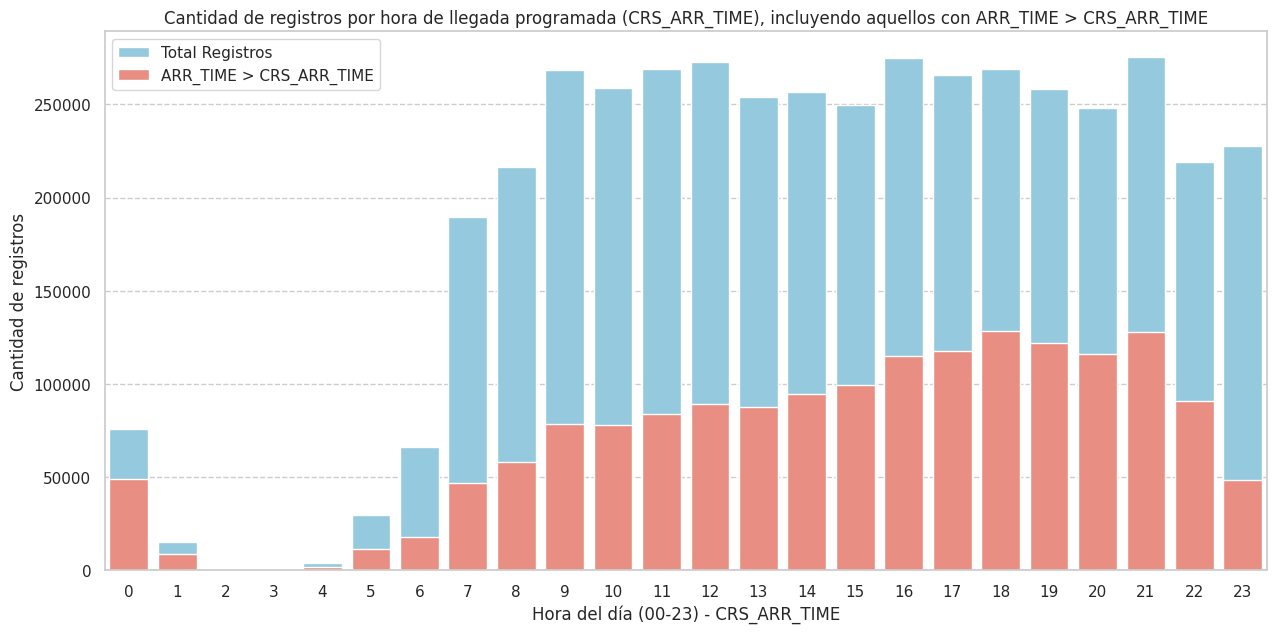

In [ ]:
# prompt: REALIZAR MISMO GRAFICO ANTERIOR CON CRS ARR TIME Y ARR TIME

# Convertir CRS_ARR_TIME y ARR_TIME a numérico, manejando errores
df1['CRS_ARR_TIME'] = pd.to_numeric(df1['CRS_ARR_TIME'], errors='coerce')
df1['ARR_TIME'] = pd.to_numeric(df1['ARR_TIME'], errors='coerce')

# Crear una nueva columna booleana indicando si ARR_TIME es mayor que CRS_ARR_TIME
df1['ARR_TIME_MAYOR'] = df1['ARR_TIME'] > df1['CRS_ARR_TIME']

# Filtrar los registros donde CRS_ARR_TIME y ARR_TIME son válidos (no NaN después de coerce)
df1_valid_arr_times = df1.dropna(subset=['CRS_ARR_TIME', 'ARR_TIME'])

# Asegurarse de que los tiempos estén en el formato militar válido (0-2359) antes de extraer la hora
df1_valid_arr_times_filtered = df1_valid_arr_times[
    (df1_valid_arr_times['CRS_ARR_TIME'] >= 0) & (df1_valid_arr_times['CRS_ARR_TIME'] <= 2359) &
    (df1_valid_arr_times['ARR_TIME'] >= 0) & (df1_valid_arr_times['ARR_TIME'] <= 2359)
]


# Extraer la hora del día (primeros dos dígitos) de CRS_ARR_TIME
df1_valid_arr_times_filtered['CRS_ARR_HOUR'] = (df1_valid_arr_times_filtered['CRS_ARR_TIME'] // 100).astype(int)

# Contar la cantidad de registros por hora de llegada programada (CRS_ARR_TIME) donde ARR_TIME > CRS_ARR_TIME
registros_arr_mayor_por_hora = df1_valid_arr_times_filtered[df1_valid_arr_times_filtered['ARR_TIME_MAYOR']]['CRS_ARR_HOUR'].value_counts().sort_index()

# Contar la cantidad total de registros por hora de llegada programada (CRS_ARR_TIME)
total_registros_arr_por_hora = df1_valid_arr_times_filtered['CRS_ARR_HOUR'].value_counts().sort_index()

# Combinar los datos en un único DataFrame para facilitar el graficado apilado
plot_data_arr = pd.DataFrame({
    'Total Registros': total_registros_arr_por_hora,
    'ARR_TIME > CRS_ARR_TIME': registros_arr_mayor_por_hora
}).fillna(0) # Llenar con 0 las horas donde no hay registros con ARR_TIME > CRS_ARR_TIME

# Crear el gráfico de barras apilado
plt.figure(figsize=(15, 7))

# Graficar la cantidad total de registros por hora de llegada programada
sns.barplot(x=plot_data_arr.index, y=plot_data_arr['Total Registros'], color='skyblue', label='Total Registros')

# Graficar la cantidad de registros con ARR_TIME > CRS_ARR_TIME por hora, apilado
sns.barplot(x=plot_data_arr.index, y=plot_data_arr['ARR_TIME > CRS_ARR_TIME'], color='salmon', label='ARR_TIME > CRS_ARR_TIME')

# Añadir etiquetas y título
plt.xlabel('Hora del día (00-23) - CRS_ARR_TIME')
plt.ylabel('Cantidad de registros')
plt.title('Cantidad de registros por hora de llegada programada (CRS_ARR_TIME), incluyendo aquellos con ARR_TIME > CRS_ARR_TIME')
plt.xticks(np.arange(0, 24)) # Asegurarse de que el eje X muestre todas las horas
plt.grid(axis='y', linestyle='--')
plt.legend()

# Mostrar el gráfico
plt.show()


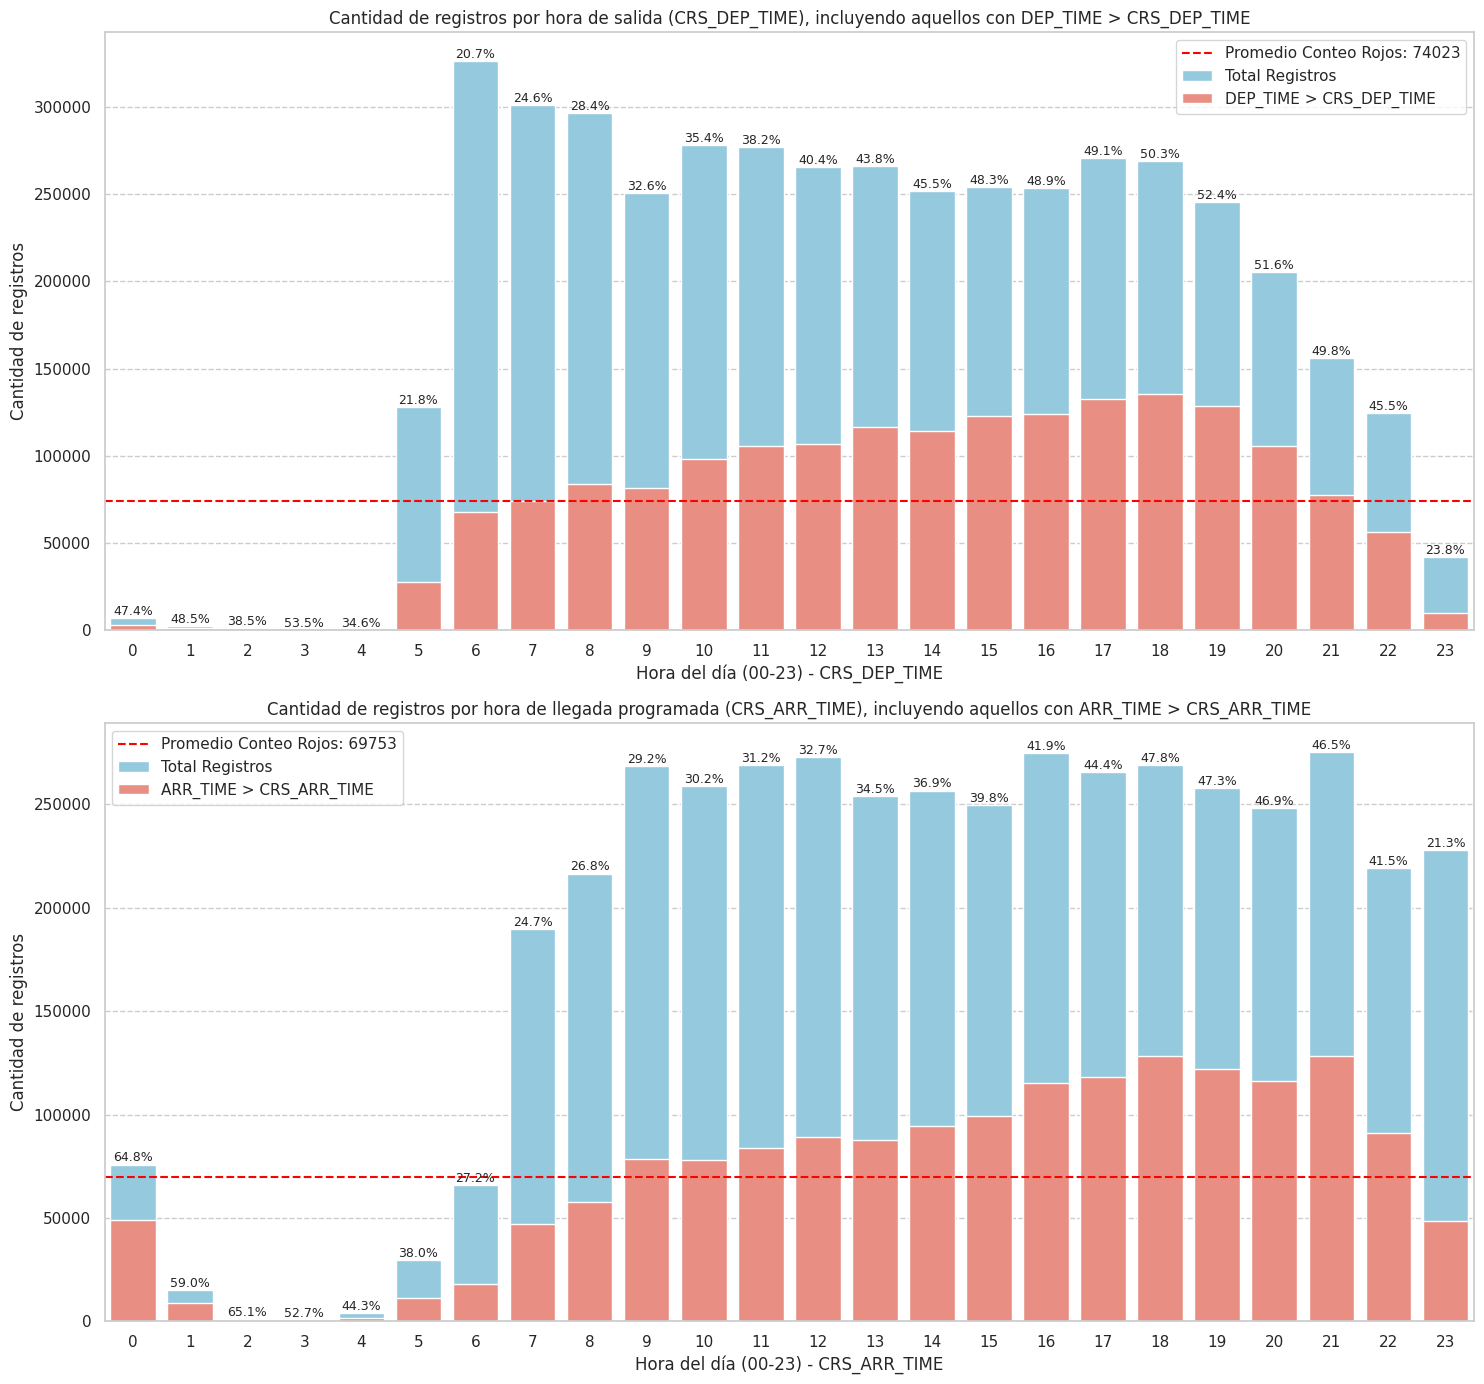

In [ ]:
# prompt: generar ambos graficos anteriores: 'Cantidad de registros por hora de salida (CRS_DEP_TIME), incluyendo aquellos con DEP_TIME > CRS_DEP_TIME' y 'Cantidad de registros por hora de llegada programada (CRS_ARR_TIME), incluyendo aquellos con ARR_TIME > CRS_ARR_TIME' uno debajo del otro. Agregar leyenda el porcentaje de las barras rojas sobre las totales. Trazar linea punteada con el promedio de los rojos

# Gráfico 1: Cantidad de registros por hora de salida (CRS_DEP_TIME), incluyendo aquellos con DEP_TIME > CRS_DEP_TIME

# Convertir CRS_DEP_TIME y DEP_TIME a numérico, manejando errores
df1['CRS_DEP_TIME'] = pd.to_numeric(df1['CRS_DEP_TIME'], errors='coerce')
df1['DEP_TIME'] = pd.to_numeric(df1['DEP_TIME'], errors='coerce')

# Crear una nueva columna booleana indicando si DEP_TIME es mayor que CRS_DEP_TIME
df1['DEP_TIME_MAYOR'] = df1['DEP_TIME'] > df1['CRS_DEP_TIME']

# Filtrar los registros donde CRS_DEP_TIME y DEP_TIME son válidos (no NaN después de coerce)
df1_valid_dep_times = df1.dropna(subset=['CRS_DEP_TIME', 'DEP_TIME'])

# Asegurarse de que los tiempos estén en el formato militar válido (0-2359) antes de extraer la hora
df1_valid_dep_times_filtered = df1_valid_dep_times[
    (df1_valid_dep_times['CRS_DEP_TIME'] >= 0) & (df1_valid_dep_times['CRS_DEP_TIME'] <= 2359) &
    (df1_valid_dep_times['DEP_TIME'] >= 0) & (df1_valid_dep_times['DEP_TIME'] <= 2359)
]

# Extraer la hora del día (primeros dos dígitos) de CRS_DEP_TIME
df1_valid_dep_times_filtered['CRS_DEP_HOUR'] = (df1_valid_dep_times_filtered['CRS_DEP_TIME'] // 100).astype(int)

# Contar la cantidad de registros por hora de salida (CRS_DEP_TIME) donde DEP_TIME > CRS_DEP_TIME
registros_dep_mayor_por_hora = df1_valid_dep_times_filtered[df1_valid_dep_times_filtered['DEP_TIME_MAYOR']]['CRS_DEP_HOUR'].value_counts().sort_index()

# Contar la cantidad total de registros por hora de salida (CRS_DEP_TIME)
total_registros_por_hora = df1_valid_dep_times_filtered['CRS_DEP_HOUR'].value_counts().sort_index()

# Combinar los datos en un único DataFrame para facilitar el graficado apilado
plot_data_dep = pd.DataFrame({
    'Total Registros': total_registros_por_hora,
    'DEP_TIME > CRS_DEP_TIME': registros_dep_mayor_por_hora
}).fillna(0) # Llenar con 0 las horas donde no hay registros con DEP_TIME > CRS_DEP_TIME

# Calcular el porcentaje de barras rojas (DEP_TIME > CRS_DEP_TIME) sobre las totales
plot_data_dep['Porcentaje_DEP_MAYOR'] = (plot_data_dep['DEP_TIME > CRS_DEP_TIME'] / plot_data_dep['Total Registros'] * 100).fillna(0)

# Calcular el promedio de los porcentajes rojos
promedio_porcentaje_dep_mayor = plot_data_dep['Porcentaje_DEP_MAYOR'].mean()

# Crear el gráfico de barras apilado
plt.figure(figsize=(15, 14)) # Aumentar el tamaño para acomodar ambos gráficos verticalmente

plt.subplot(2, 1, 1) # Primer gráfico en una cuadrícula de 2 filas y 1 columna

bars_total_dep = sns.barplot(x=plot_data_dep.index, y=plot_data_dep['Total Registros'], color='skyblue', label='Total Registros')
bars_mayor_dep = sns.barplot(x=plot_data_dep.index, y=plot_data_dep['DEP_TIME > CRS_DEP_TIME'], color='salmon', label='DEP_TIME > CRS_DEP_TIME')

# Añadir etiquetas y título
plt.xlabel('Hora del día (00-23) - CRS_DEP_TIME')
plt.ylabel('Cantidad de registros')
plt.title('Cantidad de registros por hora de salida (CRS_DEP_TIME), incluyendo aquellos con DEP_TIME > CRS_DEP_TIME')
plt.xticks(np.arange(0, 24)) # Asegurarse de que el eje X muestre todas las horas
plt.grid(axis='y', linestyle='--')
plt.legend()

# Agregar porcentaje de las barras rojas sobre las totales
for index, row in plot_data_dep.iterrows():
    if row['Total Registros'] > 0:
        percentage = (row['DEP_TIME > CRS_DEP_TIME'] / row['Total Registros']) * 100
        plt.text(index, row['Total Registros'] + 50, f'{percentage:.1f}%', ha='center', va='bottom', fontsize=9) # Ajustar posición y tamaño

# Trazar línea punteada con el promedio de los rojos (promedio del porcentaje)
# Vamos a trazar la línea en el eje Y para indicar el promedio del porcentaje en el eje X.
# Esto no es lo más intuitivo en un gráfico de conteo.
# Una alternativa más útil es trazar una línea de referencia en el eje Y para el CONTEO promedio de los rojos.
# O, si la leyenda del porcentaje es suficiente, no trazar la línea de promedio del porcentaje en el eje X.
# La solicitud original pide "promedio de los rojos", que puede interpretarse como el promedio del CONTEO o el promedio del PORCENTAJE.
# Si interpretamos como promedio del CONTEO de los rojos:
promedio_conteo_dep_mayor = plot_data_dep['DEP_TIME > CRS_DEP_TIME'].mean()
plt.axhline(promedio_conteo_dep_mayor, color='red', linestyle='--', label=f'Promedio Conteo Rojos: {promedio_conteo_dep_mayor:.0f}')
plt.legend()


# Gráfico 2: Cantidad de registros por hora de llegada programada (CRS_ARR_TIME), incluyendo aquellos con ARR_TIME > CRS_ARR_TIME

# Convertir CRS_ARR_TIME y ARR_TIME a numérico, manejando errores
df1['CRS_ARR_TIME'] = pd.to_numeric(df1['CRS_ARR_TIME'], errors='coerce')
df1['ARR_TIME'] = pd.to_numeric(df1['ARR_TIME'], errors='coerce')

# Crear una nueva columna booleana indicando si ARR_TIME es mayor que CRS_ARR_TIME
df1['ARR_TIME_MAYOR'] = df1['ARR_TIME'] > df1['CRS_ARR_TIME']

# Filtrar los registros donde CRS_ARR_TIME y ARR_TIME son válidos (no NaN después de coerce)
df1_valid_arr_times = df1.dropna(subset=['CRS_ARR_TIME', 'ARR_TIME'])

# Asegurarse de que los tiempos estén en el formato militar válido (0-2359) antes de extraer la hora
df1_valid_arr_times_filtered = df1_valid_arr_times[
    (df1_valid_arr_times['CRS_ARR_TIME'] >= 0) & (df1_valid_arr_times['CRS_ARR_TIME'] <= 2359) &
    (df1_valid_arr_times['ARR_TIME'] >= 0) & (df1_valid_arr_times['ARR_TIME'] <= 2359)
]

# Extraer la hora del día (primeros dos dígitos) de CRS_ARR_TIME
df1_valid_arr_times_filtered['CRS_ARR_HOUR'] = (df1_valid_arr_times_filtered['CRS_ARR_TIME'] // 100).astype(int)

# Contar la cantidad de registros por hora de llegada programada (CRS_ARR_TIME) donde ARR_TIME > CRS_ARR_TIME
registros_arr_mayor_por_hora = df1_valid_arr_times_filtered[df1_valid_arr_times_filtered['ARR_TIME_MAYOR']]['CRS_ARR_HOUR'].value_counts().sort_index()

# Contar la cantidad total de registros por hora de llegada programada (CRS_ARR_TIME)
total_registros_arr_por_hora = df1_valid_arr_times_filtered['CRS_ARR_HOUR'].value_counts().sort_index()

# Combinar los datos en un único DataFrame para facilitar el graficado apilado
plot_data_arr = pd.DataFrame({
    'Total Registros': total_registros_arr_por_hora,
    'ARR_TIME > CRS_ARR_TIME': registros_arr_mayor_por_hora
}).fillna(0) # Llenar con 0 las horas donde no hay registros con ARR_TIME > CRS_ARR_TIME

# Calcular el porcentaje de barras rojas (ARR_TIME > CRS_ARR_TIME) sobre las totales
plot_data_arr['Porcentaje_ARR_MAYOR'] = (plot_data_arr['ARR_TIME > CRS_ARR_TIME'] / plot_data_arr['Total Registros'] * 100).fillna(0)

# Calcular el promedio de los porcentajes rojos
promedio_porcentaje_arr_mayor = plot_data_arr['Porcentaje_ARR_MAYOR'].mean()


plt.subplot(2, 1, 2) # Segundo gráfico debajo del primero

bars_total_arr = sns.barplot(x=plot_data_arr.index, y=plot_data_arr['Total Registros'], color='skyblue', label='Total Registros')
bars_mayor_arr = sns.barplot(x=plot_data_arr.index, y=plot_data_arr['ARR_TIME > CRS_ARR_TIME'], color='salmon', label='ARR_TIME > CRS_ARR_TIME')

# Añadir etiquetas y título
plt.xlabel('Hora del día (00-23) - CRS_ARR_TIME')
plt.ylabel('Cantidad de registros')
plt.title('Cantidad de registros por hora de llegada programada (CRS_ARR_TIME), incluyendo aquellos con ARR_TIME > CRS_ARR_TIME')
plt.xticks(np.arange(0, 24)) # Asegurarse de que el eje X muestre todas las horas
plt.grid(axis='y', linestyle='--')
plt.legend()

# Agregar porcentaje de las barras rojas sobre las totales
for index, row in plot_data_arr.iterrows():
    if row['Total Registros'] > 0:
        percentage = (row['ARR_TIME > CRS_ARR_TIME'] / row['Total Registros']) * 100
        plt.text(index, row['Total Registros'] + 50, f'{percentage:.1f}%', ha='center', va='bottom', fontsize=9) # Ajustar posición y tamaño

# Trazar línea punteada con el promedio de los rojos (promedio del porcentaje)
# Si interpretamos como promedio del CONTEO de los rojos:
promedio_conteo_arr_mayor = plot_data_arr['ARR_TIME > CRS_ARR_TIME'].mean()
plt.axhline(promedio_conteo_arr_mayor, color='red', linestyle='--', label=f'Promedio Conteo Rojos: {promedio_conteo_arr_mayor:.0f}')
plt.legend()

plt.tight_layout() # Ajustar el diseño para evitar que los gráficos se solapen
plt.show()


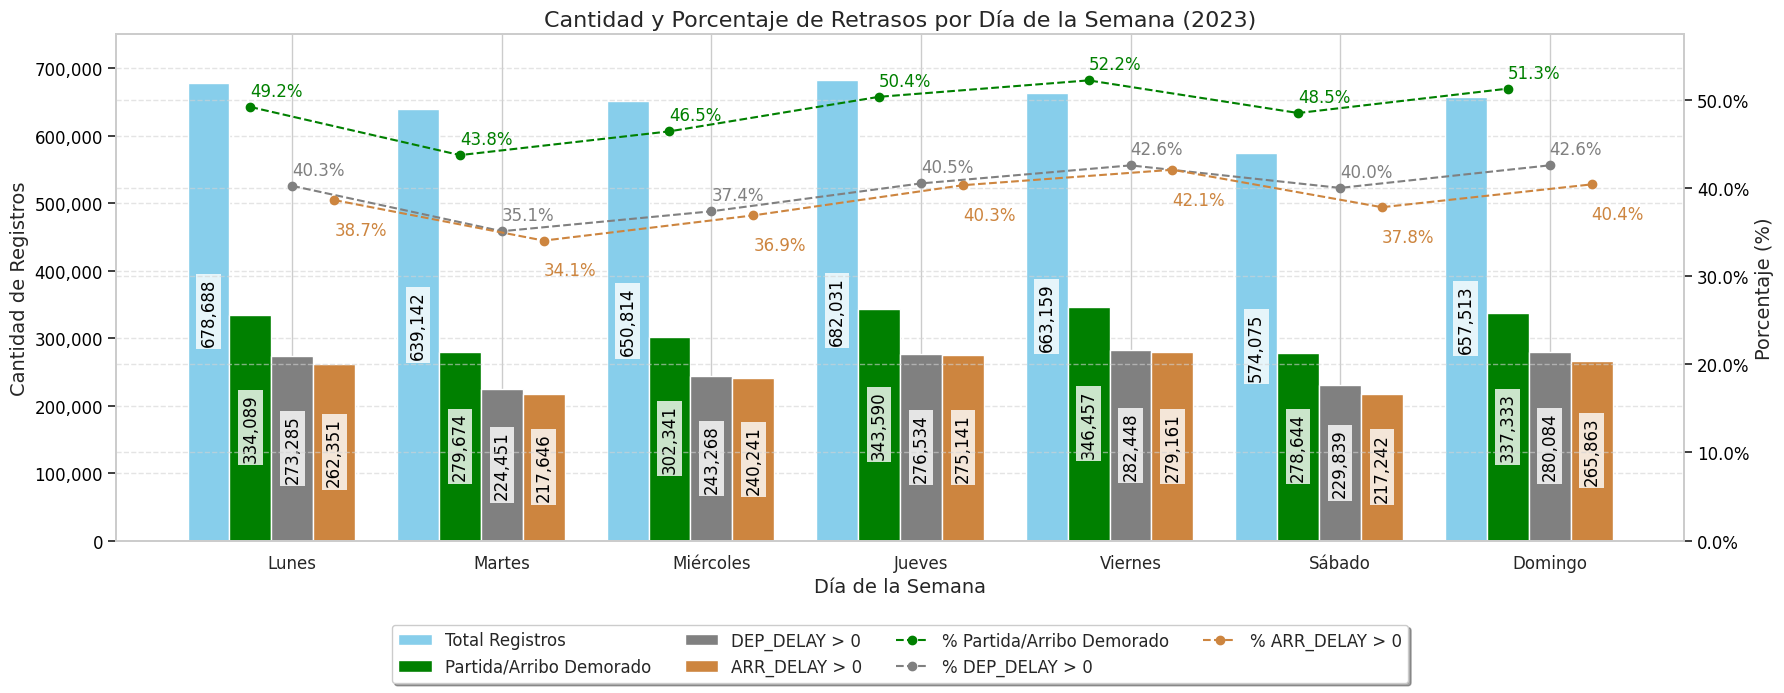

In [ ]:
# prompt: mismo grafico anterior con aumento del tamaño de todos los labels al doble del tamaño actual

# Calcular la cantidad total de registros por día de la semana
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])
df['DIA_SEMANA'] = df['FL_DATE'].dt.dayofweek  # 0 para lunes, 6 para domingo

registros_por_dia = df['DIA_SEMANA'].value_counts().sort_index()

# Mapear números de día a nombres de día
dias_semana = {
    0: 'Lunes',
    1: 'Martes',
    2: 'Miércoles',
    3: 'Jueves',
    4: 'Viernes',
    5: 'Sábado',
    6: 'Domingo'
}

# Calcular la cantidad total de registros con DEP_DELAY o ARR_DELAY > 0 (partida/arribo demorado)
df['DEP_DELAY'] = pd.to_numeric(df['DEP_DELAY'], errors='coerce').fillna(0)
df['ARR_DELAY'] = pd.to_numeric(df['ARR_DELAY'], errors='coerce').fillna(0)

df['PARTIDA_ARRIBO_DEMORADO'] = ((df['DEP_DELAY'] > 0) | (df['ARR_DELAY'] > 0)).astype(int)
partida_arribo_demorado_por_dia = df.groupby('DIA_SEMANA')['PARTIDA_ARRIBO_DEMORADO'].sum().sort_index()

# Calcular la cantidad total de DEP_DELAY > 0
dep_delay_por_dia = df[df['DEP_DELAY'] > 0]['DIA_SEMANA'].value_counts().sort_index()

# Calcular la cantidad total de ARR_DELAY > 0
arr_delay_por_dia = df[df['ARR_DELAY'] > 0]['DIA_SEMANA'].value_counts().sort_index()

# Asegurarse de que todos los días de la semana estén presentes en los conteos
dias_completos = pd.Series(index=range(7), dtype='int').fillna(0)
registros_por_dia = dias_completos.add(registros_por_dia, fill_value=0).astype(int)
partida_arribo_demorado_por_dia = dias_completos.add(partida_arribo_demorado_por_dia, fill_value=0).astype(int)
dep_delay_por_dia = dias_completos.add(dep_delay_por_dia, fill_value=0).astype(int)
arr_delay_por_dia = dias_completos.add(arr_delay_por_dia, fill_value=0).astype(int)


# Calcular los porcentajes sobre la cantidad total de registros para cada día
# Evitar división por cero si un día no tiene registros
porcentaje_partida_arribo_demorado = (partida_arribo_demorado_por_dia / registros_por_dia).replace([np.inf, -np.inf], 0).fillna(0) * 100
porcentaje_dep_delay = (dep_delay_por_dia / registros_por_dia).replace([np.inf, -np.inf], 0).fillna(0) * 100
porcentaje_arr_delay = (arr_delay_por_dia / registros_por_dia).replace([np.inf, -np.inf], 0).fillna(0) * 100


# Crear el gráfico con dos ejes Y
fig, ax1 = plt.subplots(figsize=(18, 9)) # Aumentamos el tamaño de la figura para mayor ancho

# Ancho de las barras
bar_width = 0.2
x = np.arange(len(dias_semana))

# --- Graficar las barras en el eje Y principal (cantidad) ---
# Aumentamos ligeramente la separación entre barras para mayor claridad
bar_total = ax1.bar(x - bar_width * 2, registros_por_dia, bar_width, label='Total Registros', color='skyblue')
bar_partida_arribo = ax1.bar(x - bar_width, partida_arribo_demorado_por_dia, bar_width, label='Partida/Arribo Demorado', color='green')
bar_dep_delay = ax1.bar(x, dep_delay_por_dia, bar_width, label='DEP_DELAY > 0', color='gray') # Color gris claro
bar_arr_delay = ax1.bar(x + bar_width, arr_delay_por_dia, bar_width, label='ARR_DELAY > 0', color='peru') # Color beige más claro

# Configurar eje Y principal (cantidad)
ax1.set_ylabel('Cantidad de Registros', fontsize=14) # Tamaño de fuente aumentado
ax1.tick_params(axis='y', labelcolor='black', labelsize=12) # Tamaño de fuente de ticks aumentado
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))
ax1.set_ylim(0, registros_por_dia.max() * 1.1) # Ajustar límite Y principal basado en el total de registros


# --- Crear un segundo eje Y para los porcentajes ---
ax2 = ax1.twinx()

# Graficar las líneas de porcentaje en el eje Y secundario
# Aseguramos que las líneas se grafiquen sobre los mismos puntos X que las barras centrales correspondientes
line_partida_arribo = ax2.plot(x - bar_width, porcentaje_partida_arribo_demorado, color='green', marker='o', linestyle='--', label='% Partida/Arribo Demorado', zorder=5) # Línea punteada
line_dep_delay = ax2.plot(x, porcentaje_dep_delay, color='gray', marker='o', linestyle='--', label='% DEP_DELAY > 0', zorder=5) # Línea punteada
line_arr_delay = ax2.plot(x + bar_width, porcentaje_arr_delay, color='peru', marker='o', linestyle='--', label='% ARR_DELAY > 0', zorder=5) # Línea punteada


# Configurar eje Y secundario (porcentaje)
ax2.set_ylabel('Porcentaje (%)', fontsize=14) # Tamaño de fuente aumentado
ax2.tick_params(axis='y', labelcolor='black', labelsize=12) # Tamaño de fuente de ticks aumentado
ax2.set_ylim(0, porcentaje_partida_arribo_demorado.max() * 1.1 if porcentaje_partida_arribo_demorado.max() > 0 else 100) # Ajustar límite Y secundario basado en el porcentaje máximo de retraso


ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1f}%'.format(y)))


# Etiquetas del eje X (días de la semana)
ax1.set_xticks(x)
ax1.set_xticklabels(dias_semana.values(), fontsize=12) # Tamaño de fuente de etiquetas X aumentado
ax1.set_xlabel('Día de la Semana', fontsize=14) # Tamaño de fuente de label X aumentado

# Título del gráfico
plt.title(f'Cantidad y Porcentaje de Retrasos por Día de la Semana ({Año_objetivo})', fontsize=16)

# Añadir las cantidades/rótulos dentro de las barras (en el eje Y principal)
def add_value_labels(bars, ax):
    for bar in bars:
        height = bar.get_height()
        if height > 0: # Evitar mostrar 0s innecesariamente
            ax.annotate(f'{height:,.0f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height / 2), # Centro de la barra
                        xytext=(0, 0),  # No offset
                        textcoords="offset points",
                        ha='center', va='center', # Centrado horizontal y vertical
                        rotation=90, # Rotar 90 grados
                        fontsize=12, # Tamaño de fuente aumentado
                        color='black', # Color del texto negro
                        bbox=dict(boxstyle='square,pad=0.2', fc='white', ec='none', alpha=0.8)) # Fondo blanco semi-transparente, padding reducido

add_value_labels(bar_total, ax1)
add_value_labels(bar_partida_arribo, ax1)
add_value_labels(bar_dep_delay, ax1)
add_value_labels(bar_arr_delay, ax1)


# Añadir las etiquetas de porcentaje a las líneas (en el eje Y secundario)
def add_percentage_labels(line, ax, position='above'):
    for i, txt in enumerate(line[0].get_ydata()):
        if not np.isnan(txt): # Evitar anotar NaN valores (aunque fillna(0) debería manejar esto)
            # Definir offset vertical basado en la position deseada
            if position == 'above':
                xytext = (0, 5) # 5 points vertical offset above the point
                va = 'bottom'
            elif position == 'below':
                xytext = (0, -15) # 15 points vertical offset below the point
                va = 'top'
            else: # default to above
                xytext = (0, 5)
                va = 'bottom'

            ax.annotate(f'{txt:.1f}%',
                        (line[0].get_xdata()[i], txt),
                        textcoords="offset points",
                        xytext=xytext,
                        ha='left', va=va, # Alineación
                        fontsize=12, # Tamaño de fuente aumentado
                        color=line[0].get_color(), # Mismo color que la línea
                        bbox=dict(boxstyle='square,pad=0.2', fc='none', ec='none', alpha=0.8)) # Fondo blanco semi-transparente, padding reducido

# Aplicar la función de etiquetas con posiciones específicas
# Ajustamos las posiciones para evitar solapamientos si es necesario
add_percentage_labels(line_arr_delay, ax2, position='below')
add_percentage_labels(line_dep_delay, ax2, position='above')
add_percentage_labels(line_partida_arribo, ax2, position='above')


# Unir las leyendas de ambos ejes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.15),
           fancybox=True, shadow=True, ncol=4, fontsize=12) # Tamaño de fuente de leyenda aumentado

# Configurar el grid
ax1.grid(axis='y', linestyle='--', alpha=0.6, color='lightgray', zorder=0)
ax2.grid(axis='y', linestyle='--', alpha=0.6, color='lightgray', zorder=0) # Añadir grid para el segundo eje también

# Asegurar que el layout sea correcto
plt.tight_layout(rect=[0, 0.18, 1, 1]) # Ajusta el espacio para la leyenda y etiquetas debajo

# Mostrar el gráfico
plt.show()


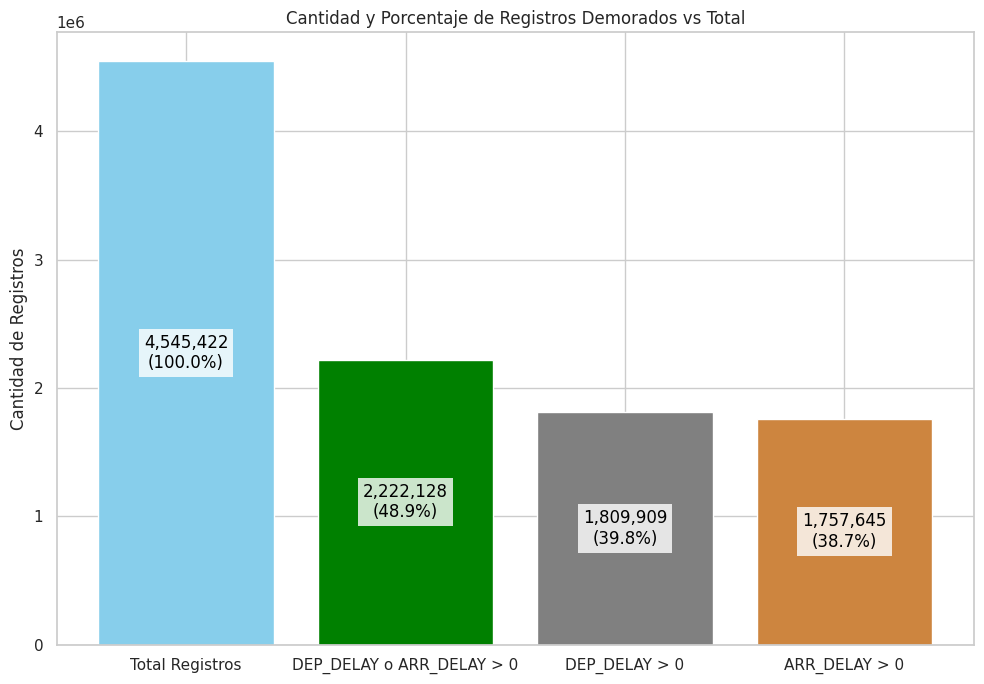

In [ ]:
# prompt: GENERAR GRAFICO DE BARRA QUE MUESTRE CANTIDAD TOTAL DE REGISTROS, CANTIDAD TOTAL DE DEP_DELAY O ARR_DELAY MAYOR A CERO, CANTIDAD TOTAL DE DEP_DELAY MAYOR A CERO Y CANTIDAD TOTAL DE ARR_DELAY MAYOR A CERO. MOSTRAR EL PORCENTAJE DE CADA BARRA VS TOTAL, COLOCAR LOS LABELS AL CENTRO DE CADA COLUMNA CON FONDO BLANCO

# Datos para el gráfico de barras
categorias = ['Total Registros', 'DEP_DELAY o ARR_DELAY > 0', 'DEP_DELAY > 0', 'ARR_DELAY > 0']
cantidad_total_registros = df.shape[0]
cantidad_partida_arribo_demorado = df['PARTIDA_ARRIBO_DEMORADO'].sum()
cantidad_dep_delay = df[df['DEP_DELAY'] > 0].shape[0]
cantidad_arr_delay = df[df['ARR_DELAY'] > 0].shape[0]

cantidades = [cantidad_total_registros, cantidad_partida_arribo_demorado, cantidad_dep_delay, cantidad_arr_delay]

# Calcular porcentajes
total_general = cantidad_total_registros
porcentajes = [(cantidad / total_general) * 100 for cantidad in cantidades]

# Crear el gráfico de barras
plt.figure(figsize=(10, 7))
bars = plt.bar(categorias, cantidades, color=['skyblue', 'green', 'gray', 'peru'])

# Añadir etiquetas y título
plt.ylabel('Cantidad de Registros')
plt.title('Cantidad y Porcentaje de Registros Demorados vs Total')
plt.xticks(rotation=0) # Mantener etiquetas horizontales

# Añadir los valores de cantidad y porcentaje en el centro de cada barra
for bar, cantidad, porcentaje in zip(bars, cantidades, porcentajes):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., height / 2,
             f'{cantidad:,.0f}\n({porcentaje:.1f}%)', # Formato: cantidad\n(porcentaje%)
             ha='center', va='center', # Centrado horizontal y vertical
             color='black', # Color del texto
             fontsize=12, # Tamaño de fuente
             bbox=dict(boxstyle='square,pad=0.3', fc='white', ec='none', alpha=0.8)) # Fondo blanco con padding y transparencia

# Ajustar el diseño
plt.tight_layout()

# Mostrar el gráfico
plt.show()


<Axes: xlabel='FL_NUMBER', ylabel='Count'>

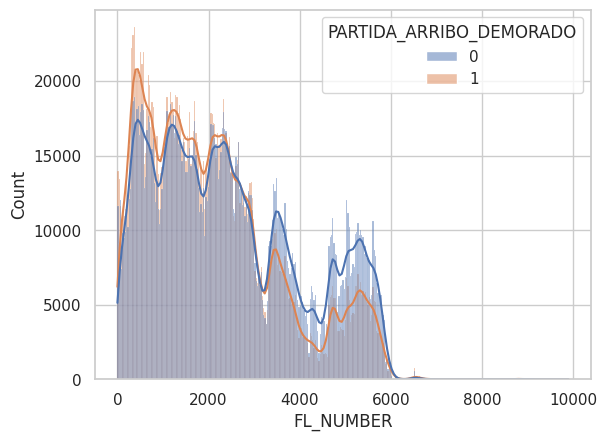

In [ ]:
# prompt: corregir error reemplazando delay por count arr_delay mayor a cero

sns.histplot(data=df, x='FL_NUMBER', hue='PARTIDA_ARRIBO_DEMORADO', kde=True)


<Axes: xlabel='AIR_TIME', ylabel='Count'>

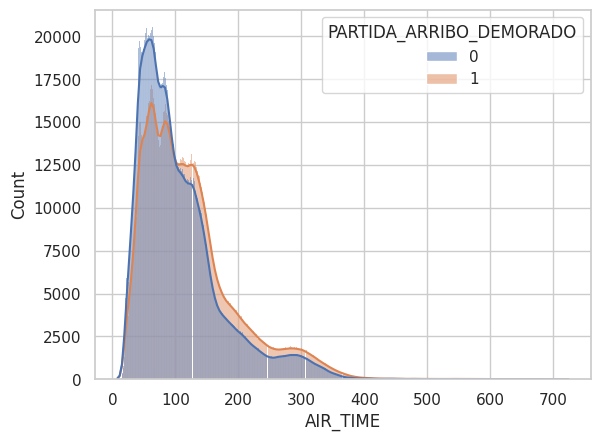

In [ ]:
# prompt: generar sns.histplot(data=df, x='FL_NUMBER', hue='PARTIDA_ARRIBO_DEMORADO', kde=True) reemplazando fl_number por air_time

sns.histplot(data=df, x='AIR_TIME', hue='PARTIDA_ARRIBO_DEMORADO', kde=True)



<Axes: xlabel='DISTANCE', ylabel='Count'>

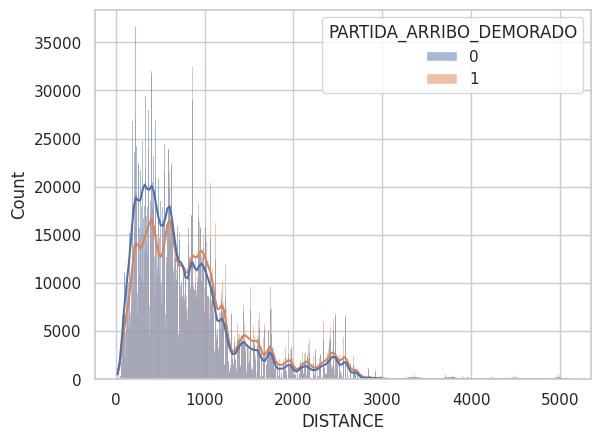

In [ ]:
sns.histplot(data=df, x='DISTANCE', hue='PARTIDA_ARRIBO_DEMORADO', kde=True)


sns.histplot(data=df, x='AIR_TIME', hue='PARTIDA_ARRIBO_DEMORADO', kde=True)
plt.title('Distribución de AIR_TIME por Partida/Arribo Demorado')
plt.xlabel('Tiempo en el Aire (minutos)')
plt.ylabel('Frecuencia')
plt.show()

In [ ]:
# prompt: realizar una tabla que coloque numero de vuelo, registros por numero de vuelo de mayor a menor. colocar el porcentaje de registros sobre la cantidad de registros totales. colocar otra columna con el % acumulado, mostrar hasta llegar al 80%

# Agrupar por número de vuelo y contar los registros
registros_por_vuelo = df['FL_NUMBER'].value_counts().reset_index()
registros_por_vuelo.columns = ['numero de vuelo', 'registros por numero de vuelo']

# Ordenar de mayor a menor
registros_por_vuelo = registros_por_vuelo.sort_values(by='registros por numero de vuelo', ascending=False)

# Calcular el porcentaje de registros sobre el total
total_registros = registros_por_vuelo['registros por numero de vuelo'].sum()
registros_por_vuelo['% registros'] = (registros_por_vuelo['registros por numero de vuelo'] / total_registros) * 100

# Calcular el porcentaje acumulado
registros_por_vuelo['% acumulado'] = registros_por_vuelo['% registros'].cumsum()

# Mostrar hasta llegar al 80%
tabla_hasta_80 = registros_por_vuelo[registros_por_vuelo['% acumulado'] <= 80].copy()

# Añadir la fila donde el % acumulado supera el 80% si no está incluida ya
if not tabla_hasta_80.empty and tabla_hasta_80.iloc[-1]['% acumulado'] < 80:
    next_row = registros_por_vuelo[registros_por_vuelo['% acumulado'] > 80].iloc[0:1]
    tabla_hasta_80 = pd.concat([tabla_hasta_80, next_row])
elif tabla_hasta_80.empty:
     next_row = registros_por_vuelo[registros_por_vuelo['% acumulado'] > 80].iloc[0:1]
     tabla_hasta_80 = pd.concat([tabla_hasta_80, next_row])



print("Tabla de registros por número de vuelo hasta alcanzar el 80% acumulado:")
pd.options.display.float_format = '{:.2f}'.format
print(tabla_hasta_80.to_string())


Tabla de registros por número de vuelo hasta alcanzar el 80% acumulado:
      numero de vuelo  registros por numero de vuelo  % registros  % acumulado
0                 777                           2241         0.05         0.05
1                 533                           2202         0.05         0.10
2                 354                           2184         0.05         0.15
3                 538                           2146         0.05         0.19
4                 366                           2126         0.05         0.24
5                 555                           2121         0.05         0.29
6                1168                           2079         0.05         0.33
7                 334                           2058         0.05         0.38
8                 312                           2054         0.05         0.42
9                 710                           2040         0.04         0.47
10               1150                           2038       

In [ ]:
# prompt: GENERAR UN MAPA DE EEUU COLOCANDO LOS AEROPUERTOS SEGUN LATITUD Y LONGITUD. AGRUPARLOS Y AL HACER ZOOM DESPLEGARLOS

!pip install folium
!pip install folium.plugins

import folium
from folium.plugins import MarkerCluster

# Limpiamos los datos para asegurarnos de tener latitud y longitud válidas
# Nos centramos en los aeropuertos de origen ya que el pedido es generar un mapa de EEUU con aeropuertos.
# Asumimos que los aeropuertos de origen están dentro de EEUU para este mapa.
aeropuertos_mapa = df_merged.dropna(subset=['Origin_Latitude', 'Origin_Longitude', 'ORIGIN']).copy()

# Eliminamos duplicados basados en el código IATA del aeropuerto de origen para no tener múltiples marcadores por el mismo aeropuerto
aeropuertos_mapa = aeropuertos_mapa.drop_duplicates(subset=['ORIGIN'])

# Crear un mapa de EE. UU. (coordenadas aproximadas del centro)
# Ajustamos el nivel de zoom inicial para que muestre EE. UU.
m = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

# Crear un grupo de marcadores para agruparlos
marker_cluster = MarkerCluster().add_to(m)

# Añadir marcadores para cada aeropuerto
for index, row in aeropuertos_mapa.iterrows():
    # Usar Origin_Latitude y Origin_Longitude
    lat = row['Origin_Latitude']
    lon = row['Origin_Longitude']
    airport_code = row['ORIGIN']
    airport_city = row['ORIGIN_CITY'] # Usamos el nombre de la ciudad de origen
    # Creamos un popup simple con información del aeropuerto
    popup_html = f"<b>Airport:</b> {airport_code}<br><b>City:</b> {airport_city}"

    # Añadir el marcador al cluster en lugar directamente al mapa
    folium.Marker(
        location=[lat, lon],
        popup=popup_html,
        tooltip=airport_code # Mostrar el código IATA al pasar el ratón
    ).add_to(marker_cluster)

# Mostrar el mapa
m

ERROR: Could not find a version that satisfies the requirement folium.plugins (from versions: none)
ERROR: No matching distribution found for folium.plugins


In [ ]:
# prompt: generar un mapa de calor de eeuu que muestre cantidad de registros segun ciudad de origen. Incluir escala de colores

# Contar la cantidad de registros por ciudad de origen
city_counts = df_merged['ORIGIN_CITY'].value_counts().reset_index()
city_counts.columns = ['ORIGIN_CITY', 'Cantidad_Registros']

# Unir la información de latitud/longitud a los conteos por ciudad.
# Usaremos la información de latitud/longitud del primer aeropuerto encontrado para cada ciudad.
city_location = df_merged[['ORIGIN_CITY', 'Origin_Latitude', 'Origin_Longitude']].drop_duplicates(subset=['ORIGIN_CITY'])

city_counts = pd.merge(city_counts, city_location, on='ORIGIN_CITY', how='left')

# Eliminar filas donde no se pudo encontrar la ubicación (si hubiera alguna)
city_counts = city_counts.dropna(subset=['Origin_Latitude', 'Origin_Longitude'])

# Crear un mapa base de EE. UU.
m = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

# Añadir una capa de HeatMapWithTime si queremos evolución temporal,
# o simplemente un HeatMap si solo queremos el total.
# Para un mapa de calor total basado en la cantidad de registros por ciudad:
from folium.plugins import HeatMap

# Preparar los datos para el HeatMap: lista de [lat, lon, peso]
# El peso será la cantidad de registros
heat_data = [[row['Origin_Latitude'], row['Origin_Longitude'], row['Cantidad_Registros']] for index, row in city_counts.iterrows()]

# Añadir la capa de mapa de calor al mapa
HeatMap(heat_data).add_to(m)

# Opcional: Añadir marcadores para ver las ciudades al hacer zoom
marker_cluster = MarkerCluster().add_to(m)
for index, row in city_counts.iterrows():
    folium.Marker(
        location=[row['Origin_Latitude'], row['Origin_Longitude']],
        popup=f"<b>City:</b> {row['ORIGIN_CITY']}<br><b>Records:</b> {row['Cantidad_Registros']}",
        tooltip=f"{row['ORIGIN_CITY']}: {row['Cantidad_Registros']} records"
    ).add_to(marker_cluster)


# Para incluir una escala de colores, Folium HeatMap no tiene una leyenda automática.
# Se puede añadir una leyenda manualmente como una ImageOverlay o Html.
# Aquí hay un ejemplo simple de cómo añadir una leyenda HTML:
legend_html =   '''
             <div style="position: fixed;
                         bottom: 50px; left: 50px; width: 150px; height: 100px;
                         border:2px solid grey; z-index:9999; font-size:14px;
                         background-color:white; opacity:0.9;">
               &nbsp; <b>Registro Count</b> <br>
               &nbsp; Low &nbsp; <i class="fa fa-square fa-1x" style="color:blue; opacity:0.5;"></i><br>
               &nbsp; Medium &nbsp; <i class="fa fa-square fa-1x" style="color:orange; opacity:0.5;"></i><br>
               &nbsp; High &nbsp; <i class="fa fa-square fa-1x" style="color:red; opacity:0.5;"></i>
               </div>
               '''

# Añadir la leyenda al mapa
m.get_root().html.add_child(folium.Element(legend_html))


# Mostrar el mapa
m

In [ ]:
# prompt: al grafico anterior quitarle la ubicacion de los aeropuertos

# Crear un mapa base de EE. UU. sin marcadores de aeropuerto
m = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

# Contar la cantidad de registros por ciudad de origen
city_counts = df_merged['ORIGIN_CITY'].value_counts().reset_index()
city_counts.columns = ['ORIGIN_CITY', 'Cantidad_Registros']

# Unir la información de latitud/longitud a los conteos por ciudad.
# Usaremos la información de latitud/longitud del primer aeropuerto encontrado para cada ciudad.
city_location = df_merged[['ORIGIN_CITY', 'Origin_Latitude', 'Origin_Longitude']].drop_duplicates(subset=['ORIGIN_CITY'])

city_counts = pd.merge(city_counts, city_location, on='ORIGIN_CITY', how='left')

# Eliminar filas donde no se pudo encontrar la ubicación (si hubiera alguna)
city_counts = city_counts.dropna(subset=['Origin_Latitude', 'Origin_Longitude'])

# Preparar los datos para el HeatMap: lista de [lat, lon, peso]
# El peso será la cantidad de registros
heat_data = [[row['Origin_Latitude'], row['Origin_Longitude'], row['Cantidad_Registros']] for index, row in city_counts.iterrows()]

# Añadir la capa de mapa de calor al mapa
HeatMap(heat_data).add_to(m)

# Opcional: Añadir una leyenda HTML (ajustar colores si es necesario)
legend_html =   '''
             <div style="position: fixed;
                         bottom: 50px; left: 50px; width: 150px; height: 100px;
                         border:2px solid grey; z-index:9999; font-size:14px;
                         background-color:white; opacity:0.9;">
               &nbsp; <b>Registro Count</b> <br>
               &nbsp; Low &nbsp; <i class="fa fa-square fa-1x" style="color:blue; opacity:0.5;"></i><br>
               &nbsp; Medium &nbsp; <i class="fa fa-square fa-1x" style="color:orange; opacity:0.5;"></i><br>
               &nbsp; High &nbsp; <i class="fa fa-square fa-1x" style="color:red; opacity:0.5;"></i>
               </div>
               '''

# Añadir la leyenda al mapa
m.get_root().html.add_child(folium.Element(legend_html))

# Mostrar el mapa
m

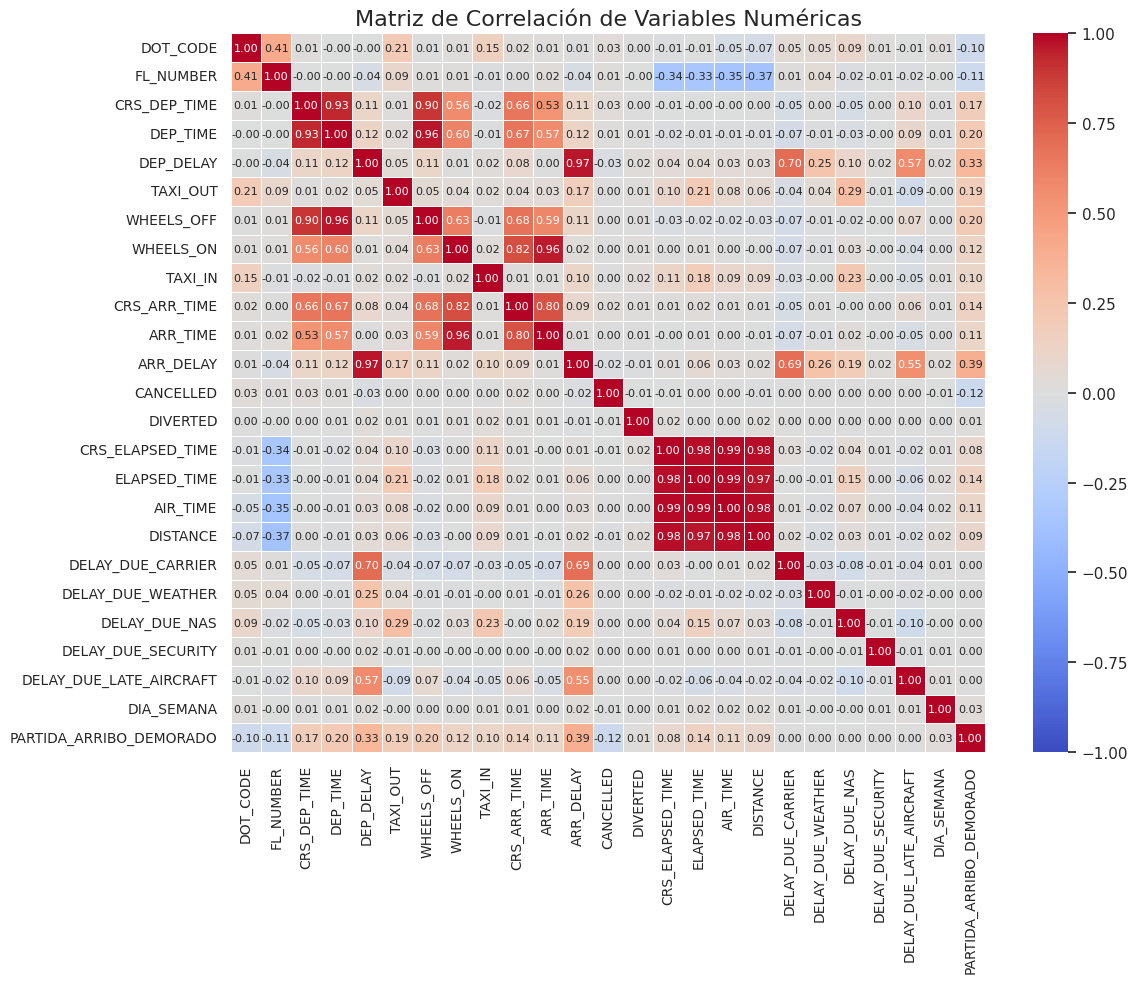

In [ ]:
# prompt: mismo heatmap anterior sin valores en blanco. colocar siempre un valor. Eje x con valores a 90 grados. Tamaño de los valores de eje y y eje x en 10

# Seleccionar solo las columnas numéricas del DataFrame
df_numeric = df.select_dtypes(include=np.number)

# Calcular la matriz de correlación
correlation_matrix = df_numeric.corr().fillna(0) # Rellenar NaNs (para pares sin correlación) con 0

# Crear el heatmap
plt.figure(figsize=(12, 10)) # Ajusta el tamaño para mejor legibilidad
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1,
            linewidths=.5, annot_kws={"size": 8}) # Ajusta el tamaño de fuente de los números

# Configurar el título
plt.title('Matriz de Correlación de Variables Numéricas', fontsize=16)

# Asegurar que las etiquetas de los ejes sean legibles
plt.xticks(rotation=90, ha='center', fontsize=10) # Eje x a 90 grados, tamaño 10
plt.yticks(rotation=0, fontsize=10) # Eje y a 0 grados, tamaño 10

# Ajustar el diseño para evitar que las etiquetas se corten
plt.tight_layout()

# Mostrar el gráfico
plt.show()


In [ ]:
# prompt: realizar un pairplot con las variables numericas

# Seleccionar solo las columnas numéricas del DataFrame
df_numeric = df.select_dtypes(include=np.number)

# Crear el pairplot
sns.pairplot(df_numeric.dropna()) # Eliminar filas con NaNs para el pairplot

# Mostrar el gráfico
plt.suptitle('Pairplot de Variables Numéricas', y=1.02) # Añadir un título general
plt.show()


NameError: name 'df' is not defined

In [ ]:
# prompt: verificar errores de mayuscula, minuscula o error de tipeo en variables categoricas

# Verificamos valores únicos y su frecuencia para columnas categóricas en df1_final
for col in ['AIRLINE_CODE', 'ORIGIN', 'DEST', 'CANCELLATION_CODE', 'ORIGIN_STATE']:
    if col in df1_final.columns and df1_final[col].dtype == 'object':
        print(f"Análisis de la columna: {col}")
        print(df1_final[col].value_counts())
        print("-" * 30)

# Para las columnas de texto como 'ORIGIN' y 'DEST' (códigos de aeropuerto),
# 'AIRLINE_CODE' y 'ORIGIN_STATE', generalmente no hay errores de mayúscula/minúscula si
# se utilizan códigos estandarizados (como códigos IATA).
# La verificación de `value_counts()` ya muestra si hay variantes con diferente capitalización.
# Si hubiera, podríamos normalizarlas, por ejemplo, a minúsculas o mayúsculas.

# Ejemplo de normalización (descomentar si se encuentran inconsistencias)
# df1_final['ORIGIN'] = df1_final['ORIGIN'].str.upper()
# df1_final['DEST'] = df1_final['DEST'].str.str.upper()
# df1_final['AIRLINE_CODE'] = df1_final['AIRLINE_CODE'].str.upper()
# df1_final['ORIGIN_STATE'] = df1_final['ORIGIN_STATE'].str.upper()

# Verificamos si hay valores inesperados en 'CANCELLATION_CODE'
# Basándonos en la descripción, esperamos 'A', 'B', 'C', o nulos (NaN)
print("Análisis de la columna: CANCELLATION_CODE")
print(df1_final['CANCELLATION_CODE'].value_counts(dropna=False))
print("-" * 30)

# Si hubiera otros valores además de NaN, 'A', 'B', 'C', serían errores de tipeo.
# En este caso, `value_counts(dropna=False)` muestra la frecuencia de los valores
# presentes y la de los valores nulos.